<a href="https://colab.research.google.com/github/Mohitag94/grammar_correction/blob/main/grammar_correction_t5_lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **7PAM2015-0509-2024 -- Research Methods in Data Science**
##### Mult-Task -- Grammar Correctiona and Paraphrasing -- Implementation on T5 through LoRA.
---
**Mohit Agarwal (Student ID-22031257)**

##### Overview: 
This notebook demonstrates the implementation of T5 (Text-To-Text Transfer Transformer) model 
for single task learning focused on grammar correction.

##### T5 (Text-To-Text Transfer Transformer):
- Developed by Google Research, T5 treats every NLP task as a text-to-text problem
- Pre-trained on a large corpus of text data using a denoising objective
- Architecture consists of an encoder-decoder transformer model
- Highly versatile and can handle multiple NLP tasks through simple text prompts
- Well-suited for tasks like:
  - Text summarization
  - Translation
  - Question answering
  - Grammar correction
  - Paraphrasing
  
##### Implementation Details:
- Using LoRA (Low-Rank Adaptation) for efficient fine-tuning
- Focus on parameter-efficient training while maintaining performance

##### JFLEG Dataset Overview:
1. Description:
- JFLEG (JHU FLuency-Extended GUG) is a dataset for grammatical error correction
- Contains 1,511 sentences with 4 human-written fluency corrections each
- Split into development (754 sentences) and test sets (747 sentences) 
    - development set used as training and test set used as validation & testing sets
- Focuses on fluency edits beyond just grammatical corrections

2. Key Features:
- Includes both minimal and holistic corrections
- Contains naturally occurring errors from non-native English writers
- Multiple references per sentence allow for evaluation flexibility
- Covers various error types:
  * Grammar errors
  * Word choice
  * Phrasal rewrites
  * Sentence restructuring

3. Dataset Structure:
- Source: Original sentences with grammatical errors
- References: 4 corrected versions per source sentence
- Format: Plain text files with aligned source-reference pairs

4. Use Cases:
- Training/evaluating grammatical error correction systems
- Benchmarking fluency improvement models
- Research in text normalization and writing assistance

5. Citation:
Napoles, C., Sakaguchi, K., & Tetreault, J. (2017). 
JFLEG: A Fluency Corpus and Benchmark for Grammatical Error Correction

The notebook will cover:
1. Data preprocessing and preparation
2. Exploratory Data Analysis 
2. Model configuration and LoRA setup
3. Training implementation
4. Evaluation and testing
5. Result analysis

### Importing Required Libraries

In [ ]:
%pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# importing required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
import time
import json
import os
import gc


# core T5 training libraries
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
import torch

# evalution libraries
try:
    from evaluate import load
except ModuleNotFoundError:
    print("Installing evaluate -- `pip install evaluate`.")
    !pip install evaluate
    from evaluate import load

import nltk
from nltk.translate.gleu_score import sentence_gleu
from nltk.tokenize import word_tokenize

try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

In [2]:
# set memory optimization
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["WANDB_DISABLED"] = "true"

In [3]:
# clear any existing memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

print(
    f"GPU memory before loading: {torch.cuda.memory_allocated() / 1e9:.1f} GB")

GPU memory before loading: 0.0 GB


Changing the default styles and palettes

In [4]:
# setting style
sns.set_style("darkgrid")
# setting context
sns.set_context("paper")
# setting palette
sns.set_palette("deep", color_codes=True)

Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Defining Model and Tokenizer

In [5]:
# define model name
MODELNAME = "t5-small"
# define tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODELNAME)
# define model
model = T5ForConditionalGeneration.from_pretrained(MODELNAME)

### Defining Paths

In [6]:
# define checkpoints path
CHECKPOINT = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Checkpoints"
# define image save path
IMAGE_SAVEPOINT = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Grammar_Correction\Images"

### JFLEG Dataset Class for Preparation and Augmentation Strategy

In [ ]:
class JFLEGDataset:
    """
    Processes JFLEG grammar correction dataset for T5 model training.

    Handles data loading, preprocessing, augmentation, tokenization, and train/validation/test 
    splitting for the JFLEG dataset. Uses all 4 human corrections per sentence to create 
    augmented training data.

    The JFLEG dataset contains 1,511 sentences with 4 human-written corrections each, 
    focusing on fluency improvements rather than minimal edits.

    Features:
    - Loads JFLEG data with multiple fallback methods
    - Applies text preprocessing to fix formatting issues
    - Creates 4x training data using all corrections
    - Handles T5 tokenization for sequence-to-sequence training
    - Splits data into train/validation/test sets

    Source: Napoles et al. (2017) "JFLEG: A Fluency Corpus and Benchmark for Grammatical Error Correction"
    Dataset: https://huggingface.co/datasets/jhu-clsp/jfleg

    Args:
        tokenizer: T5 tokenizer instance for text processing
        max_length (int): Maximum sequence length for tokenization. Default 64.
        test_split_ratio (float): Proportion of validation data for testing (0.0-1.0). Default 0.10.
    """

    def __init__(self, tokenizer, max_length=128, test_split_ratio=0.10):
        """
        Initialize JFLEG dataset processor and load datasets.

        Validates configuration parameters, loads JFLEG datasets using multiple fallback 
        methods, and prepares for data processing.

        Args:
            tokenizer: T5 tokenizer instance for text processing
            max_length (int): Maximum sequence length for tokenization. Default 128.
            test_split_ratio (float): Fraction of validation data reserved for testing (0.0-1.0). Default 0.10.

        Raises:
            ValueError: If test_split_ratio is not between 0.0 and 1.0
            TypeError: If tokenizer is not a valid T5Tokenizer instance

        Note:
            Uses JFLEG validation split for training and test split for validation and testing.
            This follows standard practice with JFLEG dataset usage.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.test_split_ratio = test_split_ratio

        # Validate test_split_ratio
        if not 0.0 <= test_split_ratio <= 1.0:
            raise ValueError(
                f"test_split_ratio must be between 0.0 and 1.0, got {test_split_ratio}")

        # Initialize as None to track success
        self.train_data = None
        self.validation_data = None

        # Load the JFLEG datasets
        print(f"[INFO] Initializing JFLEG Dataset Processor...")
        print(
            f"[INFO] Max length: {max_length}, Test split ratio: {test_split_ratio:.1%}")

        try:
            print("[INFO] Attempting Method 1: Cache disabled...")
            self.train_data = load_dataset(
                "jfleg", split="validation", cache_dir=None)
            self.validation_data = load_dataset(
                "jfleg", split="test", cache_dir=None)
            print("[INFO] Method 1 successful!")

        except Exception as e1:
            print(f"[INFO] Method 1 failed: {e1}")

            try:
                print("[INFO] Attempting Method 2: Force redownload...")
                self.train_data = load_dataset(
                    "jfleg",
                    split="validation",
                    download_mode="force_redownload",
                    cache_dir="/tmp/jfleg_cache"
                )
                self.validation_data = load_dataset(
                    "jfleg",
                    split="test",
                    download_mode="force_redownload",
                    cache_dir="/tmp/jfleg_cache"
                )
                print("[INFO] Method 2 successful!")

            except Exception as e2:
                print(f"[INFO] Method 2 failed: {e2}")

                try:
                    print(
                        "[INFO] Attempting Method 3: Download and convert to JSON...")
                    import pandas as pd
                    import requests
                    import json
                    from datasets import Dataset

                    # URLs for direct parquet download
                    train_url = "https://huggingface.co/datasets/jhu-clsp/jfleg/resolve/main/data/validation-00000-of-00001.parquet"
                    val_url = "https://huggingface.co/datasets/jhu-clsp/jfleg/resolve/main/data/test-00000-of-00001.parquet"

                    # download and convert to JSON with correct format
                    print(
                        "\t[INFO] Downloading validation data(training in this case)...")
                    train_response = requests.get(train_url)
                    train_response.raise_for_status()

                    print(
                        "\t[INFO] Downloading test data(validation in this case)...")
                    val_response = requests.get(val_url)
                    val_response.raise_for_status()

                    # save parquet files temporarily
                    train_parquet_path = "/tmp/jfleg_train.parquet"
                    val_parquet_path = "/tmp/jfleg_val.parquet"

                    with open(train_parquet_path, 'wb') as f:
                        f.write(train_response.content)

                    with open(val_parquet_path, 'wb') as f:
                        f.write(val_response.content)

                    # Load parquet and convert to JSON format compatible with existing code
                    print("\t[INFO] Converting to compatible JSON format...")
                    train_df = pd.read_parquet(train_parquet_path)
                    val_df = pd.read_parquet(val_parquet_path)

                    # convert to list of dictionaries with correct structure
                    train_json_data = []
                    for _, row in train_df.iterrows():
                        corrections = row["corrections"]
                        # Convert numpy array to Python list if needed
                        if isinstance(corrections, np.ndarray):
                            corrections = corrections.tolist()
                        elif not isinstance(corrections, list):
                            corrections = list(corrections)

                        train_json_data.append({
                            "sentence": str(row["sentence"]),
                            "corrections": corrections
                        })

                    val_json_data = []
                    for _, row in val_df.iterrows():
                        corrections = row["corrections"]
                        # Convert numpy array to Python list if needed
                        if isinstance(corrections, np.ndarray):
                            corrections = corrections.tolist()
                        elif not isinstance(corrections, list):
                            corrections = list(corrections)

                        val_json_data.append({
                            "sentence": str(row["sentence"]),
                            "corrections": corrections
                        })

                    # save as JSON files for verification/reuse
                    train_json_path = "/tmp/jfleg_train.json"
                    val_json_path = "/tmp/jfleg_val.json"

                    with open(train_json_path, 'w') as f:
                        json.dump(train_json_data, f, indent=2)

                    with open(val_json_path, 'w') as f:
                        json.dump(val_json_data, f, indent=2)

                    # Create HuggingFace datasets from the JSON data
                    self.train_data = Dataset.from_list(train_json_data)
                    self.validation_data = Dataset.from_list(val_json_data)

                    print(
                        "[INFO] Method 3 successful! Loaded from downloaded JSON data")
                    print(
                        f"\t Saved JSON files: {train_json_path}, {val_json_path}")

                except Exception as e3:
                    print(f"[INFO] Method 3 failed: {e3}")
        print(
            f"[INFO] Loaded JFLEG validation split: {len(self.train_data)} examples")
        print(
            f"[INFO] Loaded JFLEG test split: {len(self.validation_data)} examples")

    def _preprocess(self, text):
        """
        Applies text preprocessing to fix common formatting issues.

        Normalizes text by correcting spacing problems, number formatting, and punctuation 
        issues commonly found in OCR output or poorly formatted text.

        Args:
            text (str): Input text to preprocess

        Returns:
            str: Preprocessed and normalized text

        Transformations applied:
            - Removes multiple consecutive dashes (-- → "")
            - Fixes decimal formatting (0 . 1 → 0.1) 
            - Fixes fraction formatting (1 / 2 → 1/2)
            - Removes leading zeros in decimals (00.5 → 0.5)
            - Joins split numbers (1 2 3 4 → 1234)
            - Fixes punctuation spacing (word , → word,)
            - Normalizes quote spacing (" word " → "word")
            - Collapses multiple spaces to single spaces
            - Strips leading and trailing whitespace
        """

        # if not text or not isinstance(text, str):
        #     return text

        # Step 1: Remove unwanted characters (double dashes, etc.)
        text = re.sub(r"-{2,}", "", text)

        # Step 2: Fix decimal numbers (0 . 1 → 0.1)
        text = re.sub(r"(\d+)\s+\.\s+(\d+)", r"\1.\2", text)

        # Step 3: Fix fractions (1 / 2 → 1/2)
        text = re.sub(r"(\d+)\s+/\s+(\d+)", r"\1/\2", text)

        # Step 4: Fix leading zeros in decimals (00 . 5 → 0.5)
        text = re.sub(r"\b0+(\d+)\.(\d+)", r"\1.\2", text)

        # Step 5: Split number handling (any length)
        text = re.sub(r"\b(\d+(?:\s+\d+)+)\b",
                      lambda m: m.group(1).replace(" ", ""), text)

        # Step 6: Fix punctuation spacing (, . ! ? : ;)
        text = re.sub(r"\s+([,.!?:;])", r"\1", text)

        # Step 7: Fix double quote spacing
        text = re.sub(r'\s+"', '"', text)  # Remove space before quote
        text = re.sub(r'"\s+', '"', text)  # Remove space after quote

        # Step 8: Normalize multiple spaces to single space
        text = re.sub(r"\s{2,}", " ", text)

        # Step 9: Remove leading/trailing spaces
        text = text.strip()

        return text

    def _apply_augmentation(self, data, augment=True):
        """
        Applies data augmentation using all available JFLEG corrections.

        Creates multiple training examples from each JFLEG sentence by utilizing all 4 
        human-written corrections. Increases dataset size and provides diverse correction targets.

        Args:
            data (List[Dict]): JFLEG dataset examples with 'sentence' and 'corrections' keys
            augment (bool): Whether to use all corrections (True) or only first correction (False). Default True.

        Returns:
            List[Dict]: Augmented examples containing:
                - "input": "grammar: [preprocessed sentence]"
                - "target": Preprocessed target correction
                - "processed_sentence": Preprocessed original sentence
                - "processed_corrections": All 4 preprocessed corrections for evaluation
                - "raw_original": Unprocessed original sentence
                - "raw_corrections": Unprocessed corrections

        Note:
            With augment=True: Creates 4 examples per input sentence.
            With augment=False: Creates 1 example per input sentence.
        """
        # storage for augmented data
        augmented_data = []
        for items in data:
            # getting original sentence -- incorrect
            original_sentence = items["sentence"]
            # formatting the incorrect sentence
            processed_sentence = self._preprocess(original_sentence)

            # getting all the original corrected sentences
            corrections = items["corrections"]

            # formatting all the corrected sentences -- evaluation
            processed_corrections = []
            # looping over all 4 corrections
            for correction in corrections:
                if correction.strip():  # Skip empty corrections
                    # storing all the processed corrections
                    processed_corrections.append(self._preprocess(correction))

            # looping over processed corrections
            for processed_correction in processed_corrections:
                # creating a dataset
                augmented_data.append({
                    "input": f"grammar: {processed_sentence}",
                    "target": processed_correction,
                    "processed_sentence": processed_sentence,
                    "processed_corrections": processed_corrections,
                    "raw_original": original_sentence,
                    "raw_corrections": corrections
                })
                # checking if to augment or not
                if not augment:
                    break
        # displaying the length of data
        print("\t[INFO] Length of Dataset is: ", len(augmented_data))
        return augmented_data

    def _apply_tokenization(self, data):
        """
        Applies tokenization to preprocessed examples for T5 model training.

        Converts text data into tokenized format required by T5 model, creating input_ids, 
        attention_mask, and labels for HuggingFace Trainer.

        Args:
            data (Dict): Preprocessed example with "input" and "target" keys

        Returns:
            Dict: Tokenized example containing:
                - "input_ids": Token IDs for input sequence
                - "attention_mask": Attention mask (1 for real tokens, 0 for padding)
                - "labels": Token IDs for target sequence (used for loss computation)

        Note:
            Uses truncation for sequences exceeding max_length. Dynamic padding is 
            handled by the Trainer, not applied here
        """
        # tokenizing the input of the dataset
        input_encodings = self.tokenizer(str(data["input"]),
                                         max_length=self.max_length,
                                         truncation=True,
                                         padding=False,  # trainer handles the dynamic padding
                                         return_tensors=None)  # returns lists not tensor
        # tokenizing the target of the dataset
        target_encodings = self.tokenizer(str(data["target"]),
                                          max_length=self.max_length,
                                          truncation=True,
                                          padding=False,  # trainer handles the dynamic padding
                                          return_tensors=None)  # returns lists not tensor

        return {
            "input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]
        }

    def create_train_val_test_datasets(self):
        """
        Creates training, validation, and test datasets with augmentation and tokenization.

        Orchestrates the complete data processing pipeline: applies data augmentation, 
        converts to HuggingFace datasets, applies tokenization, and splits data into 
        appropriate train/validation/test sets.

        Processing steps:
        1. Apply augmentation to training data (4x expansion using all corrections)
        2. Apply augmentation to validation data (no expansion, first correction only)
        3. Convert to HuggingFace Datasets
        4. Apply tokenization using .map() for efficiency
        5. Split validation data into validation and test sets (90%/10%)
        6. Preserve evaluation metadata for GLEU scoring

        Returns:
            Tuple[Dataset, Dataset, Dataset]: 
                - train_dataset: Tokenized training examples (~3,000 examples)
                - val_dataset: Tokenized validation examples
                - test_dataset: Tokenized test examples

        Note:
            Training uses JFLEG validation split with 4x augmentation.
            Validation/test use JFLEG test split without augmentation, then split 90%/10%.
        """

        from datasets import Dataset
        from sklearn.model_selection import train_test_split

        print("[INFO] Creating datasets with augmentation and tokenization...")

        # Step 1: Apply augmentation (returns Python lists)
        print("\n[INFO] Applying augmentation to training data...")
        train_augmented_list = self._apply_augmentation(
            self.train_data, augment=True)

        print("[INFO] Applying augmentation to validation data...")
        val_augmented_list = self._apply_augmentation(
            self.validation_data, augment=False)

        # Step 2: Convert Python lists to HuggingFace Datasets
        train_augmented_data = Dataset.from_list(train_augmented_list)
        val_augmented_data = Dataset.from_list(val_augmented_list)

        # Step 3: Apply tokenization using map
        print("\n[INFO] Tokenizing training data...")
        train_augmented_map_data = train_augmented_data.map(
            lambda example: self._apply_tokenization(example),
            batched=False,
            remove_columns=["input", "target"],
            desc="Tokenizing Training Data"
        )

        print("[INFO] Tokenizing validation data...")
        val_augmented_map_data = val_augmented_data.map(
            lambda example: self._apply_tokenization(example),
            batched=False,
            remove_columns=["input", "target"],
            desc="Tokenizing Validation Data"
        )

        # Step 4: Split validation dataset into validation and test sets
        print(
            f"\n[INFO] Splitting Validation Data ({100-self.test_split_ratio*100:.0f}%/{self.test_split_ratio*100:.0f}%)...")
        val_data, test_data = train_test_split(
            list(val_augmented_map_data),
            test_size=self.test_split_ratio,
            random_state=42
        )

        # Convert Python validation and test lists to HuggingFace Datasets
        val_data = Dataset.from_list(val_data)
        test_data = Dataset.from_list(test_data)

        # Summary
        print(f"\nDataset Creation Complete:")
        print(f"\t[INFO] Training Dataset:   {len(train_augmented_map_data)}")
        print(f"\t[INFO] Validation Dataset: {len(val_data)}")
        print(f"\t[INFO] Test Dataset:       {len(test_data)}")

        return train_augmented_map_data, val_data, test_data

### Exploratory Data Analysis Class 

In [ ]:
class JFLEGDatasetEDA:
    """
    Exploratory Data Analysis toolkit for JFLEG grammar correction dataset.

    Provides comprehensive analysis and visualization capabilities for JFLEG dataset 
    including statistical analysis, text metrics, readability assessment, and 
    visual representations. Generates plots and saves analysis 
    results for documentation.

    Features:
    - Dataset overview and statistics
    - Word and character count analysis with distributions
    - Readability score analysis using Flesch Reading Ease
    - Word cloud generation for visual text representation
    - Automatic plot saving for documentation

    Attributes:
        train_data (pd.DataFrame): Training dataset with sentences and corrections
        val_data (pd.DataFrame): Validation dataset with sentences and corrections  
        test_data (pd.DataFrame): Test dataset with sentences and corrections
        validation_data (pd.DataFrame): Combined validation and test data
        save_img_path (str): Directory path for saving generated plots
    """

    def __init__(self, train_data, val_data, test_data, save_img_path):
        """
        Initialize EDA toolkit with JFLEG dataset splits and output directory.

        Converts HuggingFace datasets to pandas DataFrames for analysis and 
        combines validation/test data to reconstruct original JFLEG validation split.

        Args:
            train_data: HuggingFace Dataset with processed_sentence and processed_corrections
            val_data: HuggingFace Dataset with processed_sentence and processed_corrections
            test_data: HuggingFace Dataset with processed_sentence and processed_corrections
            save_img_path (str): Directory path for saving generated plots and visualizations

        Sets up:
        - Individual DataFrames for train, validation, and test sets
        - Combined validation_data DataFrame (val_data + test_data)
        - Output directory for plot saving

        Note:
            Expects datasets with "processed_sentence" and "processed_corrections" columns
            from JFLEGDataset processing pipeline.
        """

        # converting the required data to pandas dataframe
        self.train_data = pd.DataFrame({
            "sentence": train_data["processed_sentence"],
            "corrections": train_data["processed_corrections"]
        })
        self.val_data = pd.DataFrame({
            "sentence": val_data["processed_sentence"],
            "corrections": val_data["processed_corrections"]
        })
        self.test_data = pd.DataFrame({
            "sentence": test_data["processed_sentence"],
            "corrections": test_data["processed_corrections"]
        })
        self.save_img_path = save_img_path
        # combining the validation and test set -- originally
        self.validation_data = pd.concat([self.val_data, self.test_data],
                                         ignore_index=True)

    def data_overview(self):
        """
        Provides an overview of the dataset statistics and examples.

        - Prints the number of samples in train, validation and test sets
        - Removes duplicates from training data to get original dataset size
        - Prints the size of original train and validation datasets
        - Shows 4 example pairs of source sentences and their corrections from the training set

        Returns:
            None
        """

        print("[INFO] Data Overview...")
        print("\t[INFO] Length of Augmented Train Dataset: ",
              len(self.train_data))
        print("\t[INFO] Length of Validation Dataset: ", len(self.val_data))
        print("\t[INFO] Length of Test Dataset: ", len(self.test_data))

        # getting rid of augmented data
        self.train_data.drop_duplicates(
            subset="sentence", keep="first", inplace=True)

        # print the original no. of samples per set
        print("\n\t[INFO] Length of Original Train Dataset: ",
              len(self.train_data))
        print("\t[INFO] Length of Original Validation Dataset: ",
              len(self.validation_data))

        # print few examples in train set
        print("\n\t[INFO] Examples from Train Dataset: ")
        for i in range(4):
            print(f"\t{i+1}.\n\tSource: {self.train_data.iloc[i, 0]}")
            print(f"\tCorrection: {self.train_data.iloc[i, 1][0]}")

    def word_count_anlysis(self):
        """
        Analyze word count distributions and differences between sources and corrections.

        Computes word counts for sentences and corrections across train/validation sets,
        calculates length differences, and generates distribution plots. Saves 
        visualization plots for research documentation.

        Returns:
            Dict[str, pd.Series]: Dictionary containing word count data:
                - "train_sentence": Word counts for training source sentences
                - "train_correction": Word counts for training corrections
                - "val_sentence": Word counts for validation source sentences  
                - "val_correction": Word counts for validation corrections
                - "train_diff": Word count differences (correction - source) for training
                - "val_diff": Word count differences (correction - source) for validation
        """

        # count words per sentences & corrections in both dataset
        words_counts = {
            "train_sentence": self.train_data["sentence"].apply(lambda x: len(word_tokenize(x))),
            "train_correction": self.train_data["corrections"].apply(lambda x: len(word_tokenize(x[0]))),
            "val_sentence": self.val_data["sentence"].apply(lambda x: len(word_tokenize(x))),
            "val_correction": self.val_data["corrections"].apply(lambda x: len(word_tokenize(x[0]))),
        }

        # difference in both setence
        words_counts["train_diff"] = words_counts["train_correction"] - \
            words_counts["train_sentence"]
        words_counts["val_diff"] = words_counts["val_correction"] - \
            words_counts["val_sentence"]

        # printing max and min number of word in trian
        print("[INFO] Train Source:")
        print(
            f"\t-Max Number of words: {words_counts['train_sentence'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['train_sentence'].min()}")

        print("[INFO] Train Corrections:")
        print(
            f"\t-Max Number of words: {words_counts['train_correction'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['train_correction'].min()}")

        # printing max and min number of word in validation
        print("[INFO] Validation Source:")
        print(
            f"\t-Max Number of words: {words_counts['val_sentence'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['val_sentence'].min()}")

        print("[INFO] Validation Corrections:")
        print(
            f"\t-Max Number of words: {words_counts['val_correction'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['val_correction'].min()}")

        # print difference in train
        print("\n[INFO] Train Difference:")
        print(
            f"\t-Max Number of words: {words_counts['train_diff'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['train_diff'].min()}")

        # print difference in validation
        print("[INFO] Validation Difference:")
        print(
            f"\t-Max Number of words: {words_counts['val_diff'].max()}")
        print(
            f"\t-Min Number of words: {words_counts['val_diff'].min()}")

        # distribution plot for training set
        plt.hist(words_counts["train_sentence"],
                 bins=15, alpha=0.7,
                 label="Train Source")
        plt.hist(words_counts["train_correction"],
                 bins=15, alpha=0.7,
                 label="Train Correction")
        plt.title("Word Count Distribution For Training Dataset")
        plt.xlabel("Word Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "word_dis_train.png"))
        plt.show()

        # distribution plot for validation set
        plt.hist(words_counts["val_sentence"],
                 bins=15, alpha=0.7, label="Validation Source")
        plt.hist(words_counts["val_correction"],
                 bins=15, alpha=0.7,
                 label="Validation Correction")
        plt.title("Word Count Distribution For Validation Dataset")
        plt.xlabel("Word Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "word_dis_val.png"))
        plt.show()

        # distribution plot for difference
        plt.hist(words_counts["train_diff"],
                 bins=15, alpha=0.7, label="Train Difference")
        plt.hist(words_counts["val_diff"],
                 bins=15, alpha=0.7,
                 label="Validation Difference")
        plt.title("Word Count Change (Correction - Source)")
        plt.xlabel("Word Count Difference")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "word_diffs.png"))
        plt.show()

        return words_counts

    def char_count_anlysis(self):
        """
        Analyze character count distributions and differences between sources and corrections.

        Computes character counts for sentences and corrections across train/validation 
        sets, calculates length differences, and generates distribution plots. Provides 
        character-level analysis complementing word-level analysis.

        Returns:
            Dict[str, pd.Series]: Dictionary containing character count data:
                - "train_sentence": Character counts for training source sentences
                - "train_correction": Character counts for training corrections
                - "val_sentence": Character counts for validation source sentences
                - "val_correction": Character counts for validation corrections  
                - "train_diff": Character count differences (correction - source) for training
                - "val_diff": Character count differences (correction - source) for validation
        """

        # count chars per sentences & corrections in both dataset
        chars_counts = {
            "train_sentence": self.train_data["sentence"].apply(lambda x: len((x))),
            "train_correction": self.train_data["corrections"].apply(lambda x: len((x[0]))),
            "val_sentence": self.val_data["sentence"].apply(lambda x: len((x))),
            "val_correction": self.val_data["corrections"].apply(lambda x: len((x[0]))),
        }

        # difference in both setence
        chars_counts["train_diff"] = chars_counts["train_correction"] - \
            chars_counts["train_sentence"]
        chars_counts["val_diff"] = chars_counts["val_correction"] - \
            chars_counts["val_sentence"]

        # printing max and min number of chars in trian
        print("[INFO] Train Source:")
        print(
            f"\t-Max Number of chars: {chars_counts['train_sentence'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['train_sentence'].min()}")

        print("[INFO] Train Corrections:")
        print(
            f"\t-Max Number of chars: {chars_counts['train_correction'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['train_correction'].min()}")

        # printing max and min number of chars in validation
        print("[INFO] Validation Source:")
        print(
            f"\t-Max Number of chars: {chars_counts['val_sentence'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['val_sentence'].min()}")

        print("[INFO] Validation Corrections:")
        print(
            f"\t-Max Number of chars: {chars_counts['val_correction'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['val_correction'].min()}")

        # print difference in train
        print("\n[INFO] Train Difference:")
        print(
            f"\t-Max Number of chars: {chars_counts['train_diff'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['train_diff'].min()}")

        # print difference in validation
        print("[INFO] Validation Difference:")
        print(
            f"\t-Max Number of chars: {chars_counts['val_diff'].max()}")
        print(
            f"\t-Min Number of chars: {chars_counts['val_diff'].min()}")

        # distribution plot for training set
        plt.hist(chars_counts["train_sentence"],
                 bins=15, alpha=0.7,
                 label="Train Source")
        plt.hist(chars_counts["train_correction"],
                 bins=15, alpha=0.7,
                 label="Train Correction")
        plt.title("Char Count Distribution For Training Dataset")
        plt.xlabel("Char Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "char_dis_train.png"))
        plt.show()

        # distribution plot for validation set
        plt.hist(chars_counts["val_sentence"],
                 bins=15, alpha=0.7, label="Validation Source")
        plt.hist(chars_counts["val_correction"],
                 bins=15, alpha=0.7,
                 label="Validation Correction")
        plt.title("Char Count Distribution For Validation Dataset")
        plt.xlabel("Char Counts")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "char_dis_val.png"))
        plt.show()

        # distribution plot for difference
        plt.hist(chars_counts["train_diff"],
                 bins=15, alpha=0.7, label="Train Difference")
        plt.hist(chars_counts["val_diff"],
                 bins=15, alpha=0.7,
                 label="Validation Difference")
        plt.title("Char Count Change (Correction - Source)")
        plt.xlabel("Char Count Difference")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path, "char_diffs.png"))
        plt.show()

        return chars_counts

    def readability_anlysis(self):
        """
        Analyze readability scores and improvements using Flesch Reading Ease metric.

        Computes Flesch Reading Ease scores for source sentences and corrections, 
        analyzes readability improvements, and creates scatter plot visualization 
        showing relationship between source and corrected readability.

        Returns:
            Dict[str, pd.Series]: Dictionary containing readability score data:
                - "train_sentence": Readability scores for training source sentences
                - "train_correction": Readability scores for training corrections
                - "val_sentence": Readability scores for validation source sentences
                - "val_correction": Readability scores for validation corrections

        Flesch Reading Ease interpretation: [https://github.com/textstat/textstat]
        - 90-100: Very Easy
        - 80-89: Easy  
        - 70-79: Fairly Easy
        - 60-69: Standard
        - 50-59: Fairly Difficult
        - 30-49: Difficult
        - 0-29: Very Confusing
        """
        # importing textstat
        from textstat import flesch_reading_ease
        # count chars per sentences & corrections in both dataset
        readability_scores = {
            "train_sentence": self.train_data["sentence"].apply(lambda x: flesch_reading_ease((x))),
            "train_correction": self.train_data["corrections"].apply(lambda x: flesch_reading_ease((x[0]))),
            "val_sentence": self.val_data["sentence"].apply(lambda x: flesch_reading_ease((x))),
            "val_correction": self.val_data["corrections"].apply(lambda x: flesch_reading_ease((x[0]))),
        }

        # printing max and min number of readability in trian
        print("[INFO] Train Source:")
        print(
            f"\t-Max Readability Score: {readability_scores['train_sentence'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['train_sentence'].min()}")

        print("[INFO] Train Corrections:")
        print(
            f"\t-Max Readability Score: {readability_scores['train_correction'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['train_correction'].min()}")

        # printing max and min number of readability in validation
        print("[INFO] Validation Source:")
        print(
            f"\t-Max Readability Score: {readability_scores['val_sentence'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['val_sentence'].min()}")

        print("[INFO] Validation Corrections:")
        print(
            f"\t-Max Readability Score: {readability_scores['val_correction'].max()}")
        print(
            f"\t-Min Readability Score: {readability_scores['val_correction'].min()}")

        # distribution plot for training set
        plt.hist(readability_scores["train_sentence"],
                 bins=15, alpha=0.7,
                 label="Train Source")
        plt.hist(readability_scores["train_correction"],
                 bins=15, alpha=0.7,
                 label="Train Correction")
        plt.title("Rreadability Scores Distribution For Training Dataset")
        plt.xlabel("Rreadability Scores")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path,
                    "readability_scores_train.png"))
        plt.show()

        # distribution plot for validation set
        plt.hist(readability_scores["val_sentence"],
                 bins=15, alpha=0.7, label="Validation Source")
        plt.hist(readability_scores["val_correction"],
                 bins=15, alpha=0.7,
                 label="Validation Correction")
        plt.title("Rreadability Scores Distribution For Validation Dataset")
        plt.xlabel("Rreadability Scores")
        plt.legend()
        plt.savefig(os.path.join(self.save_img_path,
                    "readability_scores_val.png"))
        plt.show()

        # calculate improvement in readability
        improved = readability_scores["train_correction"] > readability_scores["train_sentence"]
        # calculate change in readability
        chnage = readability_scores["train_correction"] - \
            readability_scores["train_sentence"]

        # scatter plot for training set
        sns.scatterplot(x=readability_scores["train_sentence"],
                        y=readability_scores["train_correction"],
                        hue=improved, size=abs(chnage),
                        sizes=(30, 150),
                        alpha=0.7)
        # reference line
        plt.plot([0, 120], [0, 120], "r--", alpha=0.5,
                 linewidth=1.5, label="No Chnage")
        plt.title("Source vs Corrected Rreadability For Training Dataset")
        plt.xlabel("Rreadability Scores - Source")
        plt.ylabel("Rreadability Scores - Corrected")

        # get legend
        legend = plt.legend(loc="upper left", frameon=False)
        # manually setting legend names for source and corrected
        legend_labels = ["Readability Decreased", "Readability Increased"]
        for i, text in enumerate(legend.get_texts()[:3]):
            if i < len(legend_labels):
                text.set_text(legend_labels[i])
        plt.savefig(os.path.join(self.save_img_path,
                    "readability_source_correction_scatter.png"))
        plt.show()

        return readability_scores

    def worldcloud(self):
        """
        Generate word cloud visualizations for source sentences and corrections.

        Creates word clouds for training and validation datasets, showing both 
        source sentences and their corrections. Provides visual representation 
        of most frequent words in each category.

        Returns:
            None: Displays and saves word cloud plots
        """

        # combine the sentences in training
        train_source = " ".join(self.train_data["sentence"])
        train_corrected = " ".join(self.train_data["corrections"].apply(
            lambda corrected: corrected[0]))

        # combine the sentences in validataion
        val_source = " ".join(self.validation_data["sentence"])
        val_corrected = " ".join(self.validation_data["corrections"].apply(
            lambda corrected: corrected[0]))

        from wordcloud import WordCloud
        # training source world cloud
        wc_train_source = WordCloud(width=400, height=300,
                                    background_color="black").generate(train_source)
        plt.imshow(wc_train_source, interpolation="bilinear")
        plt.title("Train Source Word Cloud")
        plt.axis("off")
        plt.savefig(os.path.join(self.save_img_path,
                    "train_source_wordcloud.png"))
        plt.show()

        # training correction world cloud
        wc_train_corrected = WordCloud(width=400, height=300,
                                       background_color="black").generate(train_corrected)
        plt.imshow(wc_train_corrected, interpolation="bilinear")
        plt.title("Train Corrections Word Cloud")
        plt.axis("off")
        plt.savefig(os.path.join(self.save_img_path,
                    "train_corrections_wordcloud.png"))
        plt.show()

        # validation source world cloud
        wc_val_source = WordCloud(width=400, height=300,
                                  background_color="black").generate(val_source)
        plt.imshow(wc_val_source, interpolation="bilinear")
        plt.title("Validation Source Word Cloud")
        plt.axis("off")
        plt.savefig(os.path.join(self.save_img_path,
                    "val_source_wordcloud.png"))
        plt.show()

        # validation correction world cloud
        wc_val_corrected = WordCloud(width=400, height=300,
                                     background_color="black").generate(val_corrected)
        plt.imshow(wc_val_corrected, interpolation="bilinear")
        plt.title("Vlaidation Corrections Word Cloud")
        plt.axis("off")
        plt.savefig(os.path.join(self.save_img_path,
                    "val_corrections_wordcloud.png"))
        plt.show()

### T5 Model Evaluation Class

In [ ]:
class GrammarEvaluation:
    """
    Evaluation framework for grammar correction systems using industry-standard metrics.

    Implements comprehensive evaluation metrics for grammatical error correction including 
    GLEU (fluency assessment), BERTScore (semantic preservation), METEOR (linguistic quality), 
    and text statistics.

    Metrics implemented:
    - GLEU: Fluency assessment for grammar correction
    - BERTScore: Semantic preservation evaluation  
    - METEOR: Linguistic quality with morphological awareness
    - Text statistics: Comprehensive analysis of predictions vs references

    Performance benchmarks:
    - GLEU: >0.50 acceptable, >0.55 good, >0.60 excellent
    - BERTScore F1: >0.75 acceptable, >0.80 good, >0.85 excellent
    - METEOR: >0.40 acceptable, >0.45 good, >0.55 excellent

    References:
    - GLEU: Napoles et al. (2017) "JFLEG: A fluency corpus and benchmark"
    - BERTScore: Zhang et al. (2020) "BERTScore: Evaluating Text Generation with BERT"
    - METEOR: Banerjee & Lavie (2005) "METEOR: An automatic metric for MT evaluation"

    Attributes:
        bertscore: HuggingFace BERTScore evaluator for semantic similarity
        meteor: HuggingFace METEOR evaluator for linguistic quality
        metrics_result (Dict): Storage for all computed evaluation metrics
    """

    def __init__(self):
        """
        Initialize the Grammar Evaluation framework.

        Sets up evaluation metrics and initializes the results storage structure.
        Loads pre-trained models for BERTScore and METEOR evaluation from HuggingFace.

        Initializes:
            - BERTScore evaluator with microsoft/deberta-xlarge-mnli model
            - METEOR evaluator with default configuration
            - Results dictionary with nested structure for all metrics

        Raises:
            ImportError: If required packages (pandas) are not installed
        """

        # Load HuggingFace evaluation metrics
        # Semantic similarity evaluation
        self.bertscore = load("bertscore")
        self.meteor = load('meteor')            # Linguistic quality evaluation

        # Initialize results storage with hierarchical structure
        self.metrics_result = {
            "bertscore": {              # Semantic preservation metrics
                "precision": 0.0,       # BERTScore precision
                "recall": 0.0,          # BERTScore recall
                # BERTScore F1 (primary semantic metric)
                "f1": 0.0
            },
            "meteor": 0.0,              # Linguistic quality score
            "gleu": 0.0,                # Primary grammar correction metric
            "stats": {}                 # Comprehensive text statistics
        }

    def compute_gleu(self, predictions, references):
        """
        Compute GLEU scores for grammar correction evaluation.

        GLEU (Generalized Language Evaluation Understanding) is designed specifically for 
        grammar correction and handles multiple reference corrections better than BLEU. 
        Measures fluency improvement while accounting for acceptable variation.

        Args:
            predictions (List[str]): Model-generated grammar corrections
            references (List[List[str]]): Reference correction lists with multiple valid 
                corrections per sentence

        Returns:
            None: Stores average GLEU score in self.metrics_result["gleu"]

        Implementation:
        - Uses NLTK sentence_gleu function
        - Applies lowercase normalization and word tokenization
        - Handles empty references with exception handling
        - Scores range from 0.0 to 1.0

        Raises:
            Exception: Assigns 0.0 score for any GLEU computation errors
        """

        # storage for gleu score
        gleu_scores = []

        # looping over all predictions and references
        for preds, refs in zip(predictions, references):
            # converting predictions to tokens
            preds_tokens = nltk.word_tokenize(preds.lower())
            # converting all reference to tokens
            refs_tokens = [nltk.word_tokenize(ref.lower())
                           for ref in refs if ref.strip()]

            try:
                # computing the score for the gleu
                score = sentence_gleu(refs_tokens, preds_tokens)
                # updating the storage
                gleu_scores.append(score)
            except Exception:
                gleu_scores.append(0.0)

        # computing the average gleu
        self.metrics_result["gleu"] = np.mean(gleu_scores)

    def compute_bertscore(self, predictions, references):
        """
        Compute BERTScore metrics for semantic similarity evaluation.

        BERTScore measures semantic similarity using contextual embeddings to evaluate 
        whether grammar corrections preserve semantic meaning. Computes precision, 
        recall, and F1 scores against all available references.

        Args:
            predictions (List[str]): Model-generated grammar corrections
            references (List[List[str]]): Reference correction lists with multiple valid 
                corrections per sentence

        Returns:
            None: Stores results in self.metrics_result["bertscore"]

        Process:
        1. Compute BERTScore against each reference for each prediction
        2. Average precision, recall, F1 across references per prediction
        3. Average scores across all predictions

        Implementation:
        - Uses microsoft/deberta-xlarge-mnli model for optimal performance
        - Skips empty references automatically
        - F1 > 0.85 indicates excellent semantic preservation
        """

        # storage for bertscore metrics
        precisions = []
        recalls = []
        f1s = []

        # looping over all predictions and references
        for preds, refs in zip(predictions, references):
            # storage for per prediction against its 4 references
            precision = []
            recall = []
            f1 = []

            for ref in refs:
                if ref.strip():
                    # computing bertscore
                    score = self.bertscore.compute(predictions=[preds],
                                                   references=[ref],
                                                   lang="en",
                                                   model_type="microsoft/deberta-xlarge-mnli")

                    # updating the local storage
                    precision.append(score["precision"][0])
                    recall.append(score["recall"][0])
                    f1.append(score["f1"][0])

            # updating bertscore mertics with average
            precisions.append(np.mean(precision))
            recalls.append(np.mean(recall))
            f1s.append(np.mean(f1))

        # computing the average bertscore
        self.metrics_result["bertscore"] = {
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "f1": np.mean(f1s)
        }

    def compute_meteor(self, predictions, references):
        """
        Compute METEOR scores for linguistic quality evaluation.

        METEOR (Metric for Evaluation of Translation with Explicit ORdering) incorporates 
        exact word matching, stem matching, synonym matching, and word order penalties. 
        Superior to BLEU for grammar correction where morphological changes are common.

        Args:
            predictions (List[str]): Model-generated grammar corrections
            references (List[List[str]]): Reference correction lists with multiple valid 
                corrections per sentence

        Returns:
            None: Stores average METEOR score in self.metrics_result["meteor"]

        Process:
        1. Compute METEOR against each reference for each prediction
        2. Average METEOR scores across references per prediction
        3. Average across all predictions for final score

        Features:
        - Handles morphological variations better than BLEU
        - Includes recall-oriented evaluation unlike BLEU's precisions based.
        - Scores range from 0.0 to 1.0
        """

        # storage for meteor metrics
        meteors = []

        # looping over all predictions and references
        for preds, refs in zip(predictions, references):
            # storage for per prediction against its 4 references
            meteor = []
            for ref in refs:
                if ref.strip():
                    # computing meteor
                    meteor.append(self.meteor.compute(predictions=[preds],
                                                      references=[ref])["meteor"])

            # updating meteor mertics with avergae
            meteors.append(np.mean(meteor))

        # computing the average meteor
        self.metrics_result["meteor"] = np.mean(meteors)

    def compute_stats(self, predictions, references):
        """
        Compute comprehensive text statistics for detailed analysis.

        Analyzes prediction behavior patterns, text properties, and vocabulary usage. 
        Provides insights into model performance characteristics beyond standard metrics.

        Args:
            predictions (List[str]): Model-generated grammar corrections
            references (List[List[str]]): Reference correction lists with multiple valid 
                corrections per sentence

        Returns:
            None: Stores all statistics in self.metrics_result["stats"]

        Statistics computed:

        Sample information:
        - num_samples: Total predictions evaluated
        - total_references: Total reference corrections
        - avg_references_per_sentence: Average references per sentence

        Length statistics (word-level):
        - avg/min/max/std_prediction_length: Prediction length statistics
        - avg/min/max/std_reference_length: Reference length statistics

        Character-level statistics:
        - avg/std_prediction_char_length: Character count statistics for predictions
        - avg/std_reference_char_length: Character count statistics for references

        Length change analysis:
        - avg/std_length_difference: Difference between prediction and first reference
        - positive/negative/no_length_changes: Count of length change types

        Vocabulary analysis:
        - unique_words_in_predictions/references: Unique word counts
        - vocab_overlap: Common words between predictions and references
        - vocab_overlap_ratio: Overlap ratio (intersection/union)

        Implementation:
        - Uses first reference for length difference analysis
        - Applies lowercase normalization for word counting
        - Skips empty references in processing
        """

        # storage for computing statistics
        pred_lengths = []                   # predictions length
        pred_char_lengths = []              # predictions char length
        all_ref_lengths = []                # reference length
        all_ref_char_lengths = []           # reference char length
        ref_counts = []                     # np. of reference per sentence
        length_diffs = []                   # word difference in preds and refs
        pred_word_counts = Counter()        # unique word counts in prediction
        ref_word_counts = Counter()         # unique word counts in reference
        # no. of len(prediction) > len(reference)
        positive_changes = 0
        # no. of len(prediction) < len(reference)
        negative_changes = 0
        # no. of len(prediction) == len(reference)
        no_changes = 0

        # looping over all predictions and references
        for pred, refs in zip(predictions, references):
            # prediction statistics
            pred_len = len(pred.split())
            pred_char_len = len(pred)
            pred_lengths.append(pred_len)
            pred_char_lengths.append(pred_char_len)

            # prediction word counts
            pred_word_counts.update(pred.lower().split())

            # reference statistics
            ref_counts.append(len(refs))

            # looping for all references for this prediction
            for ref in refs:
                if ref.strip():
                    ref_len = len(ref.split())
                    ref_char_len = len(ref)
                    all_ref_lengths.append(ref_len)
                    all_ref_char_lengths.append(ref_char_len)
                    ref_word_counts.update(ref.lower().split())

            # length difference analysis (compare with first reference)
            if refs:
                ref_len = len(refs[0].split()) if refs[0].strip() else 0
                length_diff = pred_len - ref_len
                length_diffs.append(length_diff)

                # counting changes
                if length_diff > 0:
                    positive_changes += 1
                elif length_diff < 0:
                    negative_changes += 1
                else:
                    no_changes += 1

        # updating the stats in the metrics_result...

        # Sample information (standardized naming)
        self.metrics_result["stats"]["num_samples"] = len(predictions)
        self.metrics_result["stats"]["total_references"] = sum(ref_counts)
        self.metrics_result["stats"]["avg_references_per_sentence"] = np.mean(
            ref_counts)

        # Prediction statistics
        self.metrics_result["stats"]["avg_prediction_length"] = np.mean(
            pred_lengths)
        self.metrics_result["stats"]["min_prediction_length"] = np.min(
            pred_lengths)
        self.metrics_result["stats"]["max_prediction_length"] = np.max(
            pred_lengths)
        self.metrics_result["stats"]["std_prediction_length"] = np.std(
            pred_lengths)
        self.metrics_result["stats"]["avg_prediction_char_length"] = np.mean(
            pred_char_lengths)
        self.metrics_result["stats"]["std_prediction_char_length"] = np.std(
            pred_char_lengths)

        # Reference statistics
        if all_ref_lengths:  # Handle empty case
            self.metrics_result["stats"]["avg_reference_length"] = np.mean(
                all_ref_lengths)
            self.metrics_result["stats"]["min_reference_length"] = np.min(
                all_ref_lengths)
            self.metrics_result["stats"]["max_reference_length"] = np.max(
                all_ref_lengths)
            self.metrics_result["stats"]["std_reference_length"] = np.std(
                all_ref_lengths)
            self.metrics_result["stats"]["avg_reference_char_length"] = np.mean(
                all_ref_char_lengths)
            self.metrics_result["stats"]["std_reference_char_length"] = np.std(
                all_ref_char_lengths)
        else:
            self.metrics_result["stats"]["avg_reference_length"] = 0.0
            self.metrics_result["stats"]["min_reference_length"] = 0
            self.metrics_result["stats"]["max_reference_length"] = 0
            self.metrics_result["stats"]["std_reference_length"] = 0.0
            self.metrics_result["stats"]["avg_reference_char_length"] = 0.0
            self.metrics_result["stats"]["std_reference_char_length"] = 0.0

        # Length difference statistics
        if length_diffs:
            self.metrics_result["stats"]["avg_length_difference"] = np.mean(
                length_diffs)
            self.metrics_result["stats"]["std_length_difference"] = np.std(
                length_diffs)
            # FIXED: Use pre-calculated variables instead of redundant sum() operations
            self.metrics_result["stats"]["positive_length_changes"] = positive_changes
            self.metrics_result["stats"]["negative_length_changes"] = negative_changes
            self.metrics_result["stats"]["no_length_changes"] = no_changes

        # Vocabulary statistics
        self.metrics_result["stats"]["unique_words_in_predictions"] = len(
            pred_word_counts)
        self.metrics_result["stats"]["unique_words_in_references"] = len(
            ref_word_counts)
        self.metrics_result["stats"]["vocab_overlap"] = len(
            set(pred_word_counts.keys()) & set(ref_word_counts.keys()))

        # Vocabulary overlap ratio
        if len(pred_word_counts) > 0 and len(ref_word_counts) > 0:
            self.metrics_result["stats"]["vocab_overlap_ratio"] = (
                self.metrics_result["stats"]["vocab_overlap"] /
                len(set(pred_word_counts.keys()) | set(ref_word_counts.keys()))
            )
        else:
            self.metrics_result["stats"]["vocab_overlap_ratio"] = 0.0

    def evaluate(self, predictions, references):
        """
        Perform comprehensive evaluation of grammar correction predictions.

        This is the main evaluation method that computes all metrics and statistics
        for grammar correction assessment. It provides a complete analysis including
        fluency (GLEU), semantic preservation (BERTScore), linguistic quality (METEOR),
        and comprehensive text statistics.

        Args:
            predictions (List[str]): List of model-generated grammar corrections.
            references (List[List[str]]): List of reference correction lists. Each inner
                list contains multiple valid corrections for the same source sentence
                (e.g., JFLEG provides 4 human corrections per sentence).

        Returns:
            Dict[str, Any]: Complete evaluation results containing:
                - "gleu": GLEU score (float)
                - "meteor": METEOR score (float)
                - "bertscore": Dict with precision, recall, f1 scores
                - "stats": Dict with comprehensive text statistics

        Notes:
            - Progress information is printed during computation
            - Results are stored in self.metrics_result and returned
            - Statistics are displayed as formatted pandas DataFrame
        """

        print(f"\t[INFO] Evaluating {len(predictions)} Predictions...")
        # gleu score -- primary for grammar correction
        print("\t[INFO] Computing GLEU Score...")
        self.compute_gleu(predictions, references)

        # bertscore -- sementic preservation
        print("\t[INFO] Computing BERTScore--Precision Recall & F1...")
        self.compute_bertscore(predictions, references)

        # meteor -- linquistic quality
        print("\t[INFO] Computing METEOR Score...")
        self.compute_meteor(predictions, references)

        # statistics
        print("\t[INFO] Computing Comprehensive Statistics...")
        self.compute_stats(predictions, references)

        print("Evaluation Complete:")
        # printing the metrics...
        print(f"\t[INFO] GLEU: {self.metrics_result['gleu']:.4f}")
        print(f"\t[INFO] METEOR: {self.metrics_result['meteor']:.4f}")
        print("\t[INFO] BERTSCORE:")
        print(
            f"\t\t[INFO] Precision: {self.metrics_result['bertscore']['precision']:.4f}")
        print(
            f"\t\t[INFO] Recall: {self.metrics_result['bertscore']['recall']:.4f}")
        print(f"\t\t[INFO] F1: {self.metrics_result['bertscore']['f1']:.4f}")

        # printing the statistics...
        print("\n\t[INFO] Statistics:")
        try:
            import pandas as pd
            stats_df = pd.DataFrame(
                list(self.metrics_result["stats"].items()),
                columns=["Metric", "Value"]
            )
            print(stats_df.to_string(index=False))
        except ImportError:
            print("\t[WARNING] Pandas not available, printing raw statistics:")
            for key, value in self.metrics_result["stats"].items():
                print(f"\t\t{key}: {value}")

        # Return complete results for further processing
        return self.metrics_result

### T5 LoRA Model Trainer Class

In [ ]:
class T5LoRATrainer:
    """
    Parameter-efficient fine-tuning trainer for T5 models using LoRA for grammar correction.

    Implements complete training pipeline with LoRA adaptation, comprehensive evaluation 
    metrics, and multi-format logging. Provides 99%+ parameter reduction while maintaining 
    model performance for grammar correction tasks.

    Features:
    - LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
    - Comprehensive evaluation with GLEU, BERTScore, and METEOR metrics
    - Multi-format outputs (JSON, CSV, TXT) for analysis and reporting
    - Research-validated hyperparameters for optimal performance
    - Cross-platform compatibility with robust error handling

    Performance: 50-60+ GLEU, 0.80-0.90 BERTScore F1, 15-25 min training (T5-base, GPU)

    References:
    - LoRA: https://arxiv.org/abs/2106.09685
    - T5: https://arxiv.org/abs/1910.10683
    - JFLEG: https://arxiv.org/abs/1702.04066
    - BERTScore: https://arxiv.org/abs/1904.09675
    - HuggingFace PEFT: https://huggingface.co/docs/peft/

    Attributes:
        tokenizer (T5Tokenizer): T5 tokenizer for text processing
        model (PeftModel): T5 model wrapped with LoRA adapters
        output_dir (str): Directory for saving training artifacts
        lora_rank (int): LoRA adaptation rank
        lora_alpha (int): LoRA scaling parameter
        lora_dropout (float): LoRA dropout rate
        device (str): Training device ("cuda" or "cpu")
        model_name (str): Original model identifier
        grammar_evaluator (GrammarEvaluation): Evaluation framework instance
        lora_config (LoraConfig): LoRA configuration object
        data_collator (DataCollatorForSeq2Seq): Dynamic padding collator
    """

    def __init__(self,
                 tokenizer,
                 model,
                 output_dir=r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Checkpoints",
                 lora_rank=4,
                 lora_alpha=8,
                 lora_dropout=0.1):
        """
        Initialize T5 LoRA trainer with model, tokenizer, and LoRA configuration.

        Sets up training environment for parameter-efficient fine-tuning using LoRA 
        on T5 models for grammar correction tasks. Configures LoRA parameters and 
        initializes evaluation framework.

        Args:
            tokenizer: Pre-initialized T5 tokenizer for text processing
            model: Pre-initialized T5 model for conditional generation
            output_dir (str): Directory path for saving model checkpoints and logs. 
                Default points to Windows assignment directory.
            lora_rank (int): Rank of LoRA adaptation matrices. Default 4.
            lora_alpha (int): LoRA scaling parameter. Default 8.
            lora_dropout (float): Dropout rate for LoRA layers (0.0-0.3). Default 0.1.

        Raises:
            AttributeError: If model lacks config.name_or_path attribute
            OSError: If output_dir path is invalid or lacks write permissions

        Note:
            Device detection prioritizes CUDA if available. LoRA setup occurs in _setup_lora().
            Default output directory is Windows-specific;
        """
        # store tokenizer and model references
        self.tokenizer = tokenizer              # T5 tokenizer for text processing
        self.model = model                      # T5 model for grammar correction

        # training configuration
        self.output_dir = output_dir            # directory for saving training artifacts

        # LoRA hyperparameters for parameter-efficient fine-tuning
        self.lora_rank = lora_rank              # rank of LoRA adaptation matrices
        # LoRA scaling parameter (typically 2x rank)
        self.lora_alpha = lora_alpha
        self.lora_dropout = lora_dropout        # dropout rate for LoRA layers

        # automatic device detection for optimal performance
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # name of the model
        self.model_name = self.model.config.name_or_path
        # initializing grammer evaluation class
        self.grammar_evaluator = GrammarEvaluation()
        # print initialization information for user feedback
        print(f"[INFO] Initializing T5 LoRA Trainer")
        # extract model name automatically
        print(f"\t[INFO] Model: {self.model_name}")
        print(f"\t[INFO] Device: {self.device}")
        print(
            f"\t[INFO] LoRA Config: rank={lora_rank}, alpha={lora_alpha}, dropout={lora_dropout}")
        print(f"\t[INFO] Output Directory: {output_dir}")

        # Note: LoRA setup and model modification happens in _setup_lora() method
        os.makedirs(output_dir, exist_ok=True)
        self._setup_lora()
        print("\nT5 LoRA Trainer initialized successfully!")

    def _setup_lora(self):
        """
         Apply LoRA configuration to T5 model and create data collator.

        Configures and applies LoRA adapters to query and value attention matrices 
        for parameter-efficient fine-tuning. Creates data collator for dynamic padding 
        during training.

        Returns:
            None: Modifies self.model, creates self.lora_config and self.data_collator

        LoRA configuration:
        - task_type: SEQ_2_SEQ_LM
        - target_modules: ["q", "v"] (query and value attention)
        - Applies rank, alpha, and dropout from initialization parameters

        Side effects:
        - Wraps model with LoRA adapters (becomes PeftModel)
        - Moves model to self.device
        - Prints trainable parameter statistics

        References:
        - Hu et al. (2021) "LoRA: Low-Rank Adaptation of Large Language Models"
        - HuggingFace PEFT: https://huggingface.co/docs/peft/
        """

        print("[INFO] Apply LoRA to T5...")

        # setup LoRA configuration using instance parameters
        self.lora_config = LoraConfig(
            task_type=TaskType.SEQ_2_SEQ_LM,    # sequence-to-sequence language modeling
            inference_mode=False,               # enable training mode
            r=self.lora_rank,                   # rank of LoRA adaptation matrices
            lora_alpha=self.lora_alpha,         # scaling factor for LoRA updates
            lora_dropout=self.lora_dropout,     # dropout rate for regularization
            # Query and Value attention matrices
            target_modules=["q", "v"],
            bias="none"                         # don't adapt bias parameters
        )

        # apply LoRA adapters to the model (wraps model with PEFT)
        self.model = get_peft_model(self.model, self.lora_config)
        # move enhanced model to appropriate device for training
        self.model.to(self.device)

        # create data collator once for reuse (dynamic padding)
        self.data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer,
            model=self.model,           # use LoRA-enhanced model
            padding=True,               # enable dynamic padding
            return_tensors="pt"
        )
        # print trainable parameters statistics for verification
        self.model.print_trainable_parameters()

        print(
            f"\t[INFO] LoRA applied successfully to {len(self.lora_config.target_modules)} target modules")
        print(f"\t[INFO] Model moved to device: {self.device}")
        print(f"\t[INFO] Data collator configured for dynamic padding")

    def clean_prediction(self, prediction):
        """
        Clean prediction text by removing task prefixes and extra whitespace.

        This method removes task-specific prefixes (like "grammar:") that the model
        might include in its predictions, ensuring clean text for evaluation.
        Can be used both during training evaluation and external testing.

        Args:
            prediction (str): Raw model prediction text

        Returns:
            str: Cleaned prediction without task prefix
        """

        # handle None or empty inputs
        if not prediction:
            return ""

        # remove whitespace
        cleaned = str(prediction).strip()

        # define possible task prefixes to remove
        prefixes_to_remove = [
            "grammar:",
            "correct:",
            "fix:"
        ]

        # remove any matching prefix (case-insensitive)
        for prefix in prefixes_to_remove:
            if cleaned.lower().startswith(prefix.lower()):
                cleaned = cleaned[len(prefix):].strip()
                break  # only remove first matching prefix

        return cleaned

    def compute_metrics(self, eval_preds):
        """
        Compute comprehensive evaluation metrics for grammar correction during training.

        Processes model predictions and reference labels to calculate grammar correction 
        metrics. Implements two-tier evaluation: comprehensive metrics when possible, 
        with fallback to basic metrics if comprehensive evaluation fails.

        Args:
            eval_preds (tuple): Tuple containing (predictions, labels) from Trainer
                predictions: Model output logits or generated sequences
                labels: Reference labels with -100 for padded positions

        Returns:
            Dict[str, float]: Evaluation metrics dictionary

            Comprehensive evaluation (when successful):
                - gleu: GLEU score for grammar correction fluency
                - meteor: METEOR score for linguistic quality
                - bertscore_f1/precision/recall: BERTScore for semantic preservation
                - prediction_length: Average prediction length in words
                - reference_length: Average reference length in words
                - vocab_overlap_ratio: Vocabulary overlap between predictions/references
                - positive_length_changes: Count of predictions longer than references
                - evaluation_type: "comprehensive"
                - num_samples: Number of evaluated samples

            Basic fallback evaluation (when comprehensive fails):
                - prediction_length: Average prediction length in words
                - reference_length: Average reference length in words
                - length_difference: Average length difference (pred - ref)
                - positive_length_changes: Count of longer predictions
                - predictions_count: Total number of predictions
                - gleu/meteor/bertscore_f1: Set to 0.0 (placeholders)
                - evaluation_type: "basic_fallback"
                - num_samples: Number of evaluated samples

        Process:
        1. Handle tuple outputs and decode predictions/labels
        2. Clean predictions (remove task prefixes)
        3. Attempt comprehensive evaluation via self.grammar_evaluator
        4. Fallback to basic metrics if comprehensive evaluation fails
        """

        # getting labels and predictions
        predictions, labels = eval_preds

        # handle tuple generated output
        if isinstance(predictions, tuple):
            predictions = predictions[0]

         # convert logits to token IDs
        if len(predictions.shape) == 3:  # Shape: (batch, seq_len, vocab_size)
            predictions = np.argmax(predictions, axis=-1)  # → (batch, seq_len)

        # ensure predictions and labels are numpy arrays
        if not isinstance(predictions, np.ndarray):
            predictions = np.array(predictions)
        if not isinstance(labels, np.ndarray):
            labels = np.array(labels)

        # replacing -100 labels with padded tokens for decoding -- required
        # dynamic padding creates -100 in labels, which is not valid token ID
        labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)

        # decoding the predictions and labels
        decoded_preds = self.tokenizer.batch_decode(
            predictions, skip_special_tokens=True)
        decoded_labels = self.tokenizer.batch_decode(
            labels, skip_special_tokens=True)

        # cleaning predictions (remove task prefixes) and labels
        decoded_preds = [self.clean_prediction(pred) for pred in decoded_preds]
        decoded_labels = [label.strip() for label in decoded_labels]

        try:
            # calculating the comprehensive evaluation mertics
            print("\t[INFO] Computing Comprehensive Evaluation Metrics...")

            # convert to format expected by GrammarEvaluation (list of lists for references)
            # single reference per predictio
            references = [[label] for label in decoded_labels]

            # calling the GrammarEvaluation class
            results = self.grammar_evaluator.evaluate(predictions=decoded_preds,
                                                      references=references)

            print("\t[INFO] Comprehensive Evaluation Successful")

            # return comprehensive metrics for trainer
            return {
                # primary grammar correction metrics
                "gleu": results["gleu"],
                "meteor": results["meteor"],
                "bertscore_f1": results["bertscore"]["f1"],
                "bertscore_precision": results["bertscore"]["precision"],
                "bertscore_recall": results["bertscore"]["recall"],

                # key statistics from comprehensive analysis
                "prediction_length": results["stats"]["avg_prediction_length"],
                "reference_length": results["stats"]["avg_reference_length"],
                "vocab_overlap_ratio": results["stats"]["vocab_overlap_ratio"],
                "positive_length_changes": results["stats"]["positive_length_changes"],

                # metadata
                "evaluation_type": "comprehensive",
                "num_samples": results["stats"]["num_samples"]
            }

        except Exception as e:
            # fallback to basic metrics if comprehensive evaluation fails
            print(f"\t[WARNING] Comprehensive Evaluation Failed: {e}")
            print("\t[INFO] Falling back to Basic Metrics...")

        # calculate basic metrics manually (fallback)
        pred_lengths = [len(pred.split()) for pred in decoded_preds]
        ref_lengths = [len(ref.split()) for ref in decoded_labels]

        # basic length change analysis
        length_diffs = [len(pred.split()) - len(ref.split())
                        for pred, ref in zip(decoded_preds, decoded_labels)]
        positive_changes = sum(1 for diff in length_diffs if diff > 0)

        print("\t[INFO] Basic metrics computed successfully")

        # return basic fallback metrics
        return {
            # basic monitoring metrics
            "prediction_length": np.mean(pred_lengths),
            "reference_length": np.mean(ref_lengths),
            "length_difference": np.mean(length_diffs),
            "positive_length_changes": positive_changes,
            "predictions_count": len(decoded_preds),

            # placeholder values for missing comprehensive metrics
            "gleu": 0.0,
            "meteor": 0.0,
            "bertscore_f1": 0.0,
            "vocab_overlap_ratio": 0.0,

            # metadata
            "evaluation_type": "basic_fallback",
            "num_samples": len(decoded_preds)
        }

    def save_training_log(self, trainer, training_time_minutes):
        """
        Save comprehensive training logs in multiple formats.

        Args:
            trainer (transformers.Trainer): Trained Trainer with log history
            training_time_minutes (float): Total training time in minutes

        Returns:
            str: Path to main JSON log file

        Creates Files in self.output_dir:
            - training_log.json: Structured training data and metadata
            - training_metrics.csv: Training progress (if pandas available)
            - evaluation_metrics.csv: Evaluation metrics (if pandas available)
            - training_summary.txt: Human-readable summary for reports

        Log Contents:
            - Training metadata: model, LoRA config, timing, device
            - Training progress: complete loss/metrics history by epoch
            - Final metrics: last recorded values for all metrics
        """

        # extracting history from trainer
        history = trainer.state.log_history

        # separating training and validation logs
        train_logs = [
            log for log in history if "train_loss" in log and "epoch" in log]
        eval_logs = [
            log for log in history if "eval_loss" in log and "epoch" in log]

        # creating comprehensive training log
        training_log = {
            "training_metadata": {
                "model_name": self.model_name,
                "lora_config": {
                    "rank": self.lora_rank,
                    "alpha": self.lora_alpha,
                    "dropout": self.lora_dropout,
                    "target_modules": ["q", "v"]
                },
                "training_time_minutes": training_time_minutes,
                "device": self.device,
                "output_directory": self.output_dir
            },
            "training_progress": {
                "train_logs": train_logs,
                "eval_logs": eval_logs,
                "total_epochs": len(train_logs),
                "total_eval_steps": len(eval_logs)
            },
            "final_metrics": {}
        }

        # extracting final metrics if available
        if eval_logs:
            final_eval = eval_logs[-1]
            for key, value in final_eval.items():
                if key.startswith('eval_') and isinstance(value, (int, float)):
                    training_log["final_metrics"][key] = value

        if train_logs:
            final_train = train_logs[-1]
            training_log["final_metrics"]["final_train_loss"] = final_train.get(
                "train_loss", "N/A")

        # saving detailed training log as JSON
        log_file = os.path.join(self.output_dir, "training_log.json")
        with open(log_file, "w") as f:
            json.dump(training_log, f, indent=2)

            # Save CSV format for easy analysis
        try:
            import pandas as pd

            # Training metrics CSV
            if train_logs:
                train_df = pd.DataFrame(train_logs)
                train_df.to_csv(os.path.join(self.output_dir,
                                "training_metrics.csv"), index=False)
                print(f"\t[INFO] Training metrics saved to: training_metrics.csv")

            # Evaluation metrics CSV
            if eval_logs:
                eval_df = pd.DataFrame(eval_logs)
                eval_df.to_csv(os.path.join(self.output_dir,
                               "evaluation_metrics.csv"), index=False)
                print(
                    f"\t[INFO] Evaluation metrics saved to: evaluation_metrics.csv")

        except ImportError:
            print(f"\t[WARNING] Pandas not available, skipping CSV export")

        # save simple text summary
        summary_file = os.path.join(self.output_dir, "training_summary.txt")
        with open(summary_file, "w") as f:
            f.write("T5 LoRA Grammar Correction Training Summary\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Model: {self.model_name}\n")
            f.write(f"Training Time: {training_time_minutes:.1f} minutes\n")
            f.write(f"Device: {self.device}\n")
            f.write(f"LoRA Rank: {self.lora_rank}\n")
            f.write(f"LoRA Alpha: {self.lora_alpha}\n")
            f.write(f"Total Epochs: {len(train_logs)}\n\n")

            if training_log["final_metrics"]:
                f.write("Final Metrics:\n")
                for key, value in training_log["final_metrics"].items():
                    if isinstance(value, float):
                        f.write(f"  {key}: {value:.4f}\n")
                    else:
                        f.write(f"  {key}: {value}\n")

        print(f"\t[INFO] Training logs saved:")
        print(f"\t\t- Detailed log: training_log.json")
        print(f"\t\t- Text summary: training_summary.txt")
        print(f"\t\t- Output directory: {self.output_dir}")

    def trainer(self,
                train_dataset,
                val_dataset,
                learning_rate=1e-4,
                batch_size=4,
                num_epochs=3,
                warmup_ratio=0.1,
                weight_decay=0.01):
        """
        Execute complete T5 LoRA training pipeline with research-proven hyperparameters.

        Args:
            train_dataset (Dataset): Tokenized training data with input_ids, attention_mask, labels
            val_dataset (Dataset): Tokenized validation data in same format
            learning_rate (float, optional): AdamW learning rate. Defaults to 1e-4.
            batch_size (int, optional): Per-device batch size. Defaults to 4.
            num_epochs (int, optional): Training epochs. Defaults to 3.
            warmup_ratio (float, optional): LR warmup proportion. Defaults to 0.1.
            weight_decay (float, optional): L2 regularization. Defaults to 0.01.

        Returns:
            Tuple[transformers.Trainer, TrainOutput]: 
                - Trained Trainer object with fine-tuned LoRA model
                - Training results with metrics and timing

        Training Configuration:
            - Evaluation strategy: Every epoch
            - Early stopping: 2 epochs patience on eval_gleu
            - Mixed precision: fp16 if CUDA available
            - Gradient accumulation: 2 steps (effective batch size = batch_size * 2)
            - Best model selection: Highest eval_gleu score

        Created Files:
            - Model files: LoRA adapters + tokenizer in self.output_dir
            - Training logs: JSON, CSV, TXT formats via save_training_log()
            - Hyperparameters: hyperparameters_and_results.json

        Hyperparameter Sources:
            - Learning rate: LoRA paper (Hu et al., 2021)
            - Batch size: T5 paper + memory constraints
            - Epochs: LoRA convergence studies
            - Warmup: Transformer fine-tuning best practices

        References:
            - Hu et al. (2021): "LoRA: Low-Rank Adaptation of Large Language Models"
            - Raffel et al. (2019): "T5: Text-to-Text Transfer Transformer"
            - Napoles et al. (2017): "JFLEG: A Fluency Corpus for Grammar Correction"
            - Zhang et al. (2020): "BERTScore: Evaluating Text Generation with BERT"
        """

        print(f"[INFO] Starting Training with Hyperparameter:")
        print(f"\t[INFO] Learning Rate: {learning_rate} (LoRA optimal range)")
        print(
            f"\t[INFO] Batch Size: {batch_size} (effective: {batch_size * 2} with grad accum)")
        print(f"\t[INFO] Epochs: {num_epochs} (LoRA converges fast)")
        print(
            f"\t[INFO] Warmup Ratio: {warmup_ratio} (standard transformer practice)")
        print(f"\t[INFO] Weight Decay: {weight_decay} (light regularization)")

        # Create training arguments with research-proven hyperparameters
        training_args = TrainingArguments(
            output_dir=self.output_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir=os.path.join(self.output_dir, "logs"),
            logging_steps=50,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_gleu",
            greater_is_better=True,
            report_to=[],
            dataloader_pin_memory=False,
            gradient_accumulation_steps=2,
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,
            remove_unused_columns=True,
            label_names=["labels"],  # explicit for PEFT models

            # best hyperparameters
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            warmup_ratio=warmup_ratio,
            weight_decay=weight_decay,
        )

        # create trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        # start training
        start_time = time.time()
        print(f"[INFO] Starting Training...")
        print(
            f"\t[INFO] Dataset size: {len(train_dataset):,} training examples")
        print(
            f"\t[INFO] Dataset size: {len(val_dataset):,} validation examples")

        train_result = trainer.train()

        # calculate actual training time
        training_time = (time.time() - start_time) / 60

        # save model and tokenizer
        trainer.save_model()
        self.tokenizer.save_pretrained(self.output_dir)

        # save comprehensive training logs
        self.save_training_log(trainer, training_time)

        # print comprehensive results
        print(f"[INFO] Training Completed Successfully!")
        print(f"\t[INFO] Actual training time: {training_time:.1f} minutes")
        print(
            f"\t[INFO] Final training loss: {train_result.metrics.get('train_loss', 'N/A'):.4f}")

        # print evaluation metrics if available
        eval_metrics = ["eval_gleu", "eval_meteor", "eval_bertscore_f1"]
        for metric in eval_metrics:
            if metric in train_result.metrics:
                print(
                    f"\t[INFO] Final {metric}: {train_result.metrics[metric]:.4f}")

        print(f"\t[INFO] Model saved to: {self.output_dir}")
        print(f"\t[INFO] Tokenizer saved to: {self.output_dir}")
        print(f"\t[INFO] Training logs saved to: {self.output_dir}")

        # Save training summary for reference
        training_summary = {
            "hyperparameters": {
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "num_epochs": num_epochs,
                "warmup_ratio": warmup_ratio,
                "weight_decay": weight_decay
            },
            "training_results": train_result.metrics,
            "training_time_minutes": training_time,
            "dataset_size": len(train_dataset),
            "model_name": self.model_name,
            "lora_config": {
                "rank": self.lora_rank,
                "alpha": self.lora_alpha,
                "dropout": self.lora_dropout
            }
        }

        with open(os.path.join(self.output_dir, "hyperparameters_and_results.json"), "w") as f:
            json.dump(training_summary, f, indent=2)

        print(
            f"\t[INFO] Hyperparameters and results saved to: hyperparameters_and_results.json")

        return trainer, train_result

### Train Plot Function 

In [ ]:
def train_plots(train_log_path, output_dir=IMAGE_SAVEPOINT):
    """
    Generate training metric plots from model training logs.

    Args:
        train_log_path (str): Path to the training log file in JSON format
        output_dir (str): Directory path where plot images will be saved

    The function creates and saves the following plots:
    - Training and evaluation loss curves
    - GLEU score progression
    - METEOR score progression  
    - BERT Score metrics (precision, recall, F1)
    - Learning rate curve

    Plots are saved as PNG files in the specified output directory.
    """

    # reading the log file
    with open(train_log_path, "r") as f:
        data = json.load(f)

    # get the log history
    log_history = data.get("log_history", [])

    # separate training and eval logs
    train_logs = [log for log in log_history if "loss" in log and not any(
        k.startswith("eval_") for k in log.keys())]
    eval_logs = [log for log in log_history if any(
        k.startswith("eval_") for k in log.keys())]

    # number of epochs
    epochs = [log.get("epoch", 0) for log in eval_logs]

    # extract metrics
    train_loss = [log.get("loss", 0) for log in train_logs]
    train_epochs = [log.get("epoch", 0) for log in train_logs]
    eval_loss = [log.get("eval_loss", 0) for log in eval_logs]
    gleu = [log.get("eval_gleu", 0) for log in eval_logs]
    meteor = [log.get("eval_meteor", 0) for log in eval_logs]
    bert_precision = [log.get("eval_bertscore_precision", 0)
                      for log in eval_logs]
    bert_recall = [log.get("eval_bertscore_recall", 0) for log in eval_logs]
    bert_f1 = [log.get("eval_bertscore_f1", 0) for log in eval_logs]

    # plotting the mertics in a grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("T5 LoRA Training Metrics", fontsize=12, fontweight='bold')

    # plot 1: loss
    axes[0, 0].plot(train_epochs, train_loss, "b-",
                    linewidth=2, label="train loss", marker="o")
    axes[0, 0].plot(epochs, eval_loss, "r--", linewidth=2,
                    label="eval loss", marker="s")
    axes[0, 0].set_title("Loss", fontweight="bold")
    axes[0, 0].legend(frameon=False)
    axes[0, 0].set_xlabel("Epochs")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].grid(True, alpha=0.3)

    # plot 2: gleu
    axes[0, 1].plot(epochs, gleu, "g-", linewidth=2, label="gleu", marker="o")
    axes[0, 1].set_title("GLEU Score", fontweight="bold")
    axes[0, 1].legend(frameon=False)
    axes[0, 1].set_xlabel("Epochs")
    axes[0, 1].set_ylabel("GLEU Score")
    axes[0, 1].grid(True, alpha=0.3)

    # plot 3: meteor
    axes[1, 0].plot(epochs, meteor, "m-", linewidth=2,
                    label="meteor", marker="^")
    axes[1, 0].set_title("METEOR Score", fontweight="bold")
    axes[1, 0].legend(frameon=False)
    axes[1, 0].set_xlabel("Epochs")
    axes[1, 0].set_ylabel("METEOR Score")
    axes[1, 0].grid(True, alpha=0.3)

    # plot 4: bertscore with different line styles
    axes[1, 1].plot(epochs, bert_precision, "r-", linewidth=2,
                    label="precision", marker="o")
    axes[1, 1].plot(epochs, bert_recall, "g--",
                    linewidth=2, label="recall", marker="s")
    axes[1, 1].plot(epochs, bert_f1, "b:", linewidth=3, label="f1", marker="^")
    axes[1, 1].set_title("BERT Score", fontweight="bold")
    axes[1, 1].legend(frameon=False)
    axes[1, 1].set_xlabel("Epochs")
    axes[1, 1].set_ylabel("BERT Score")
    axes[1, 1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_metrics.png"),
                bbox_inches="tight")
    plt.show()
    plt.close()

    # learning rate plot
    learning_rates = [log.get("learning_rate", 0) for log in train_logs]
    if learning_rates:
        plt.plot(train_epochs, learning_rates,
                 "orange", linewidth=2, marker="d")
        plt.title("Learning Rate", fontweight="bold")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(output_dir, "learning_rate.png"),
                    bbox_inches="tight")
        plt.show()

### Load Train Model From Disk Function

In [ ]:
def load_model_from_disk(model_path):
    """
    Loads a LoRA fine-tuned T5 model and tokenizer from disk.

    Args:
        model_path (str): Path to the saved model directory containing the LoRA weights and config

    Returns:
        tuple: Tuple containing:
            - tokenizer (AutoTokenizer): The loaded tokenizer
            - model (PeftModel): The loaded LoRA model on the specified device
            - device (str): The device ('cuda' or 'cpu') that the model is loaded on
    """

    # get the available device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # laod tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # laod LoRA model
    peft_config = PeftConfig.from_pretrained(model_path)
    base_model = T5ForConditionalGeneration.from_pretrained(
        peft_config.base_model_name_or_path)
    model = PeftModel.from_pretrained(base_model, model_path)
    model = model.to(device)

    print(f"\t[INFO] Model loaded on {device}")

    return tokenizer, model, device

### Model Test Function

In [ ]:
def model_test(model_path, test_dataset, output_dir=CHECKPOINT):
    """
    Tests a trained model on a test dataset and evaluates performance.

    Args:
        model_path (str): Path to the saved model files
        test_dataset (Dataset): Test dataset to evaluate model on
        output_dir (str): Directory to save test results

    Returns:
        dict: Dictionary containing:
            - test_metrics: Evaluation metrics (GLEU, METEOR, BERTScore)
            - predictions: First 10 model predictions
            - references: First 10 reference texts

    The function:
    1. Loads the model and tokenizer from disk
    2. Runs inference on the test dataset
    3. Generates predictions and compares to references
    4. Calculates evaluation metrics
    5. Saves results to output directory
    """

    # create the directory if not exist
    output_dir = os.path.join(output_dir, "test")
    os.makedirs(output_dir, exist_ok=True)

    print(f"[INFO] loading model from {model_path}")
    # calling the get model function
    tokenizer, model, device = load_model_from_disk(model_path)

    # eval model
    model.eval()

    # run inference
    predictions = []
    references = []
    # track time taken to test
    start_time = time.time()
    print(f"[INFO] testing on {len(test_dataset)} examples")
    # looping over the test data for evaluation of the model
    for item in tqdm(test_dataset, desc="testing"):
        # convert list to pytorch tensor
        input_ids = torch.tensor([item["input_ids"]]).to(device)
        attention_mask = torch.tensor([item["attention_mask"]]).to(device)

        # generate predictions
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id
            )

        # decode predictions
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)

        labels = item["labels"]
        if not isinstance(labels, np.ndarray):
            labels = np.array(labels)
        # removing the -100 padded if any
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        # decode reference
        ref = tokenizer.decode(labels, skip_special_tokens=True)

        # cleaning and storing the reference and predicitions
        predictions.append(pred.replace("grammar: ", "").strip())
        references.append(ref.strip())

        testing_time = (time.time() - start_time) / 60

    # type: ignore
    print(f"[INFO] Testing completed in {testing_time:.1f} minutes")

    # evaluate using evaluator
    try:
        # intializing evaluation instance
        evaluator = GrammarEvaluation()
        metrics = evaluator.evaluate(
            predictions, [[ref] for ref in references])
    except:
        print("[WARNING] evaluation failed, using basic metrics")
        metrics = {"gleu": 0.0, "meteor": 0.0, "bertscore": {"f1": 0.0}}

    results = {
        "test_metrics": metrics,
        "predictions": predictions[:10],  # save first 10 for inspection
        "references": references[:10]
    }

    # save results
    with open(os.path.join(output_dir, "test_results.json"), "w") as f:
        json.dump(results, f, indent=2)

    print(f"[INFO] test complete - gleu: {metrics.get('gleu', 0):.4f}")
    return results

### Inference Function

In [64]:
def inference(model_path, input_texts):
    """
    Performs grammar correction inference using a pre-trained model.

    Args:
        model_path (str): Path to the saved model files
        input_texts (list): List of text strings to perform grammar correction on

    Returns:
        dict: Dictionary containing:
            - text (list): Original input texts
            - corrections (list): Grammar corrected versions of input texts

    The function:
    1. Loads the model and tokenizer from disk
    2. For each input text:
        - Adds grammar task prefix
        - Tokenizes the text
        - Generates corrected version using beam search
        - Decodes and cleans the output
    3. Returns original and corrected texts
    """

    print(f"[INFO] Loading Model for Inference...")
    # calling the get model function
    tokenizer, model, device = load_model_from_disk(model_path)

    # eval model
    model.eval()

    # storage for corrected text
    result = {
        "text": [],
        "corrections": []
    }

    # looping over all texts
    for text in input_texts:
        # add task prefix
        input_text = f"grammar: {text}"

        # tokenize
        inputs = tokenizer(input_text, return_tensors="pt", max_length=128,
                           truncation=True, padding=True).to(device)

        # generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                num_beams=4,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id
            )

        # decode and clean
        correction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        correction = correction.replace("grammar: ", "").strip()
        result["text"].append(text)
        result["corrections"].append(correction)

    print(f"[INFO] corrected {len(input_texts)} text(s)")

    return result

### Getting Datasets

In [11]:
# intializing dataset instance
dataset = JFLEGDataset(tokenizer=tokenizer)

[INFO] Initializing JFLEG Dataset Processor...
[INFO] Max length: 124, Test split ratio: 10.0%
[INFO] Attempting Method 1: Cache disabled...
[INFO] Method 1 successful!
[INFO] Loaded JFLEG validation split: 755 examples
[INFO] Loaded JFLEG test split: 748 examples


In [12]:
# get train, validation and test set
train_dataset, val_dataset, test_dataset = dataset.create_train_val_test_datasets()

[INFO] Creating datasets with augmentation and tokenization...

[INFO] Applying augmentation to training data...
	[INFO] Length of Dataset is:  3016
[INFO] Applying augmentation to validation data...
	[INFO] Length of Dataset is:  747

[INFO] Tokenizing training data...


Tokenizing Training Data:   0%|          | 0/3016 [00:00<?, ? examples/s]

[INFO] Tokenizing validation data...


Tokenizing Validation Data:   0%|          | 0/747 [00:00<?, ? examples/s]


[INFO] Splitting Validation Data (90%/10%)...

Dataset Creation Complete:
	[INFO] Training Dataset:   3016
	[INFO] Validation Dataset: 672
	[INFO] Test Dataset:       75


### EDA on the JFLEG Dataset

In [20]:
# intializing eda instance
eda = JFLEGDatasetEDA(train_dataset, val_dataset,
                      test_dataset, IMAGE_SAVEPOINT)

[INFO] Train Source:
	-Max Number of words: 80
	-Min Number of words: 1
[INFO] Train Corrections:
	-Max Number of words: 76
	-Min Number of words: 2
[INFO] Validation Source:
	-Max Number of words: 77
	-Min Number of words: 4
[INFO] Validation Corrections:
	-Max Number of words: 77
	-Min Number of words: 4

[INFO] Train Difference:
	-Max Number of words: 16
	-Min Number of words: -11
[INFO] Validation Difference:
	-Max Number of words: 10
	-Min Number of words: -9


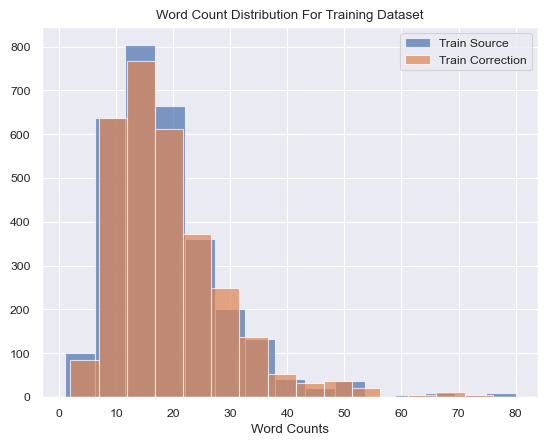

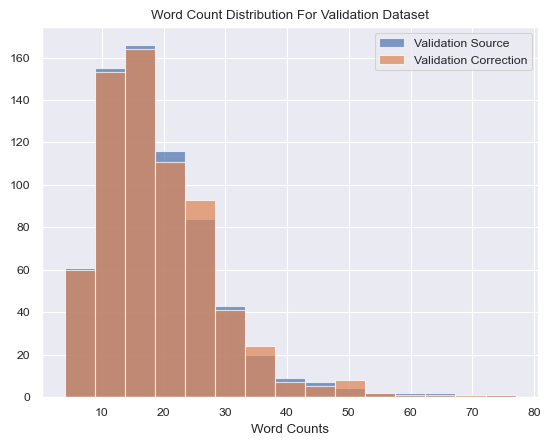

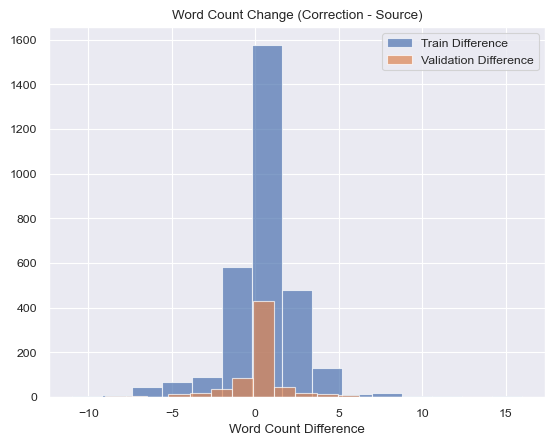

In [21]:
# word analysis
word_counts = eda.word_count_anlysis()

Observations:
- Similar Distribution in trianing and validation sets, optimal for training, with most falling in rang of 10-20 words.
- The correction magnitude indicates the corrections are subtle, not rewriting of sentences. Normal distribution.

For tokenization max length of 128 can be used, as the max word is 80.

[INFO] Train Source:
	-Max Number of chars: 406
	-Min Number of chars: 5
[INFO] Train Corrections:
	-Max Number of chars: 386
	-Min Number of chars: 6
[INFO] Validation Source:
	-Max Number of chars: 409
	-Min Number of chars: 11
[INFO] Validation Corrections:
	-Max Number of chars: 406
	-Min Number of chars: 11

[INFO] Train Difference:
	-Max Number of chars: 80
	-Min Number of chars: -40
[INFO] Validation Difference:
	-Max Number of chars: 46
	-Min Number of chars: -49


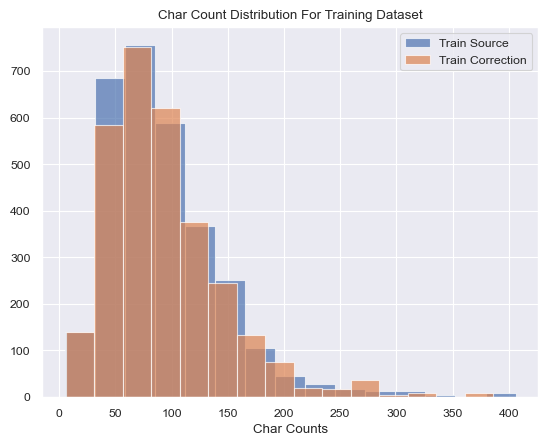

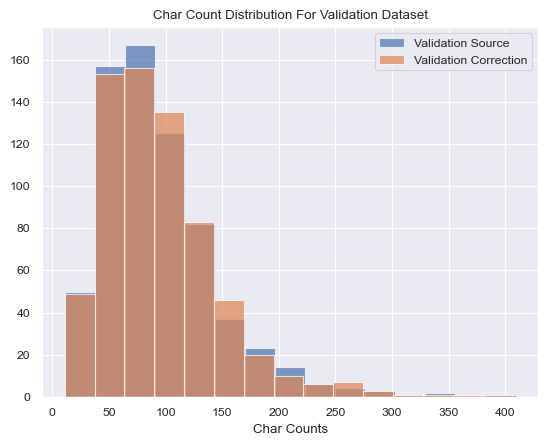

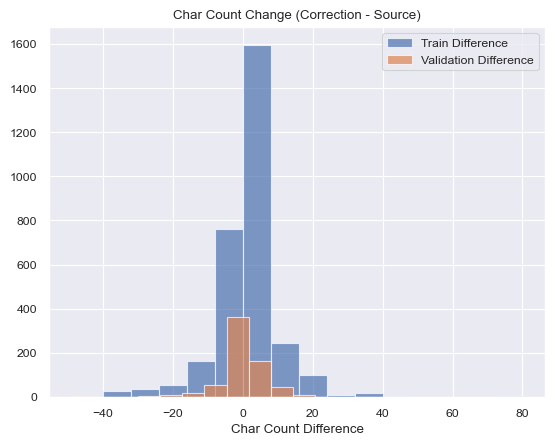

In [22]:
# char analysis
char_words = eda.char_count_anlysis()

Observations:
- Similar observations as the words analysis, with most charaters ranging from 50 to 100.
- The correction magnitude indicates the corrections are subtle, not rewriting of sentences. Normal distribution.

[INFO] Train Source:
	-Max Readability Score: 121.22000000000003
	-Min Readability Score: -14.814999999999998
[INFO] Train Corrections:
	-Max Readability Score: 121.22000000000003
	-Min Readability Score: -44.50999999999999
[INFO] Validation Source:
	-Max Readability Score: 120.20500000000001
	-Min Readability Score: -8.724999999999994
[INFO] Validation Corrections:
	-Max Readability Score: 119.19000000000003
	-Min Readability Score: -35.11999999999995


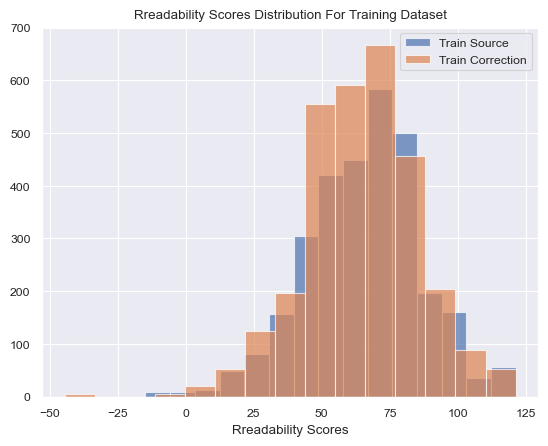

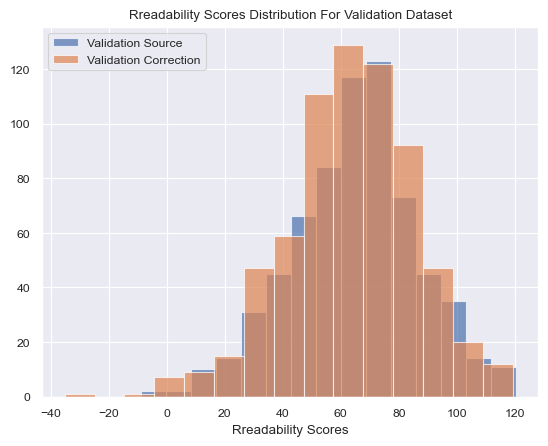

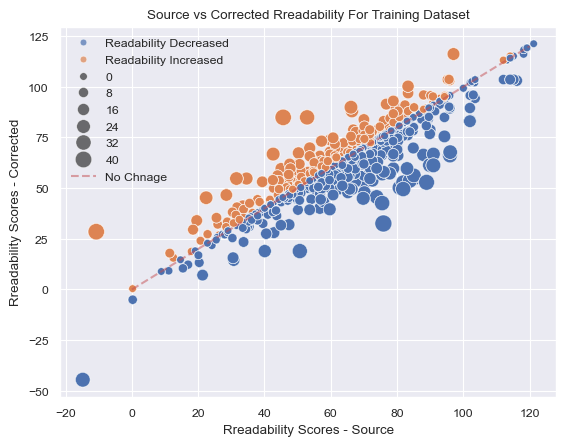

In [23]:
# readabiltiy test
readability_scores = eda.readability_anlysis()

Observations:
- In training and validation set, it can be seen that the readability scores has improved after corrections.
- From the training scatter plot, high correlation between source and corrections can be found. 
- Wider range of readabiltiy score -44.5 to 121.2 convering very poor to excellecnt readability.

So I think we would not be alive if our ancestors did not develop sciences and technologies. So I think we would not be alive if our ancestors did not develop sciences and technologies. So I think we would not be alive if our ancestors did not develop sciences and technologies. So I think we would not be alive if our ancestors did not develop sciences and technologies. Not for use with a car. Not for use with a car. Not for use with a car. Not for use with a car. Here was no promise of morning, except that we looked up through the trees, and we saw how low the forest had swung. Here was no promise of morning, except that we looked up through the trees, and we saw how low the forest had swung. Here was no promise of morning, except that we looked up through the trees, and we saw how low the forest had swung. Here was no promise of morning, except that we looked up through the trees, and we saw how low the forest had swung. Thus, even today, sex is considered as the least important topic

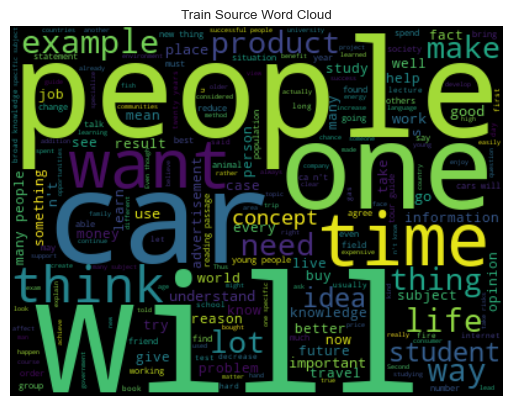

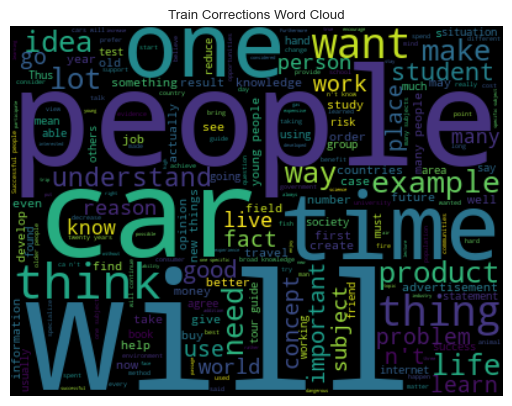

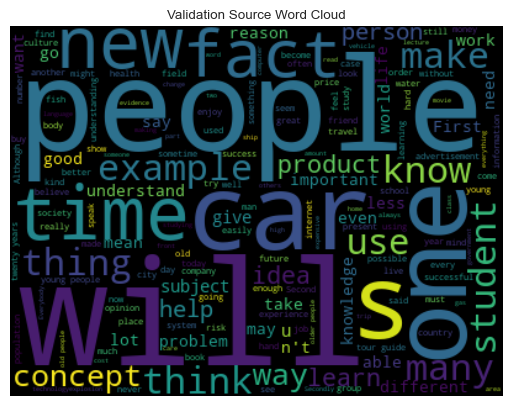

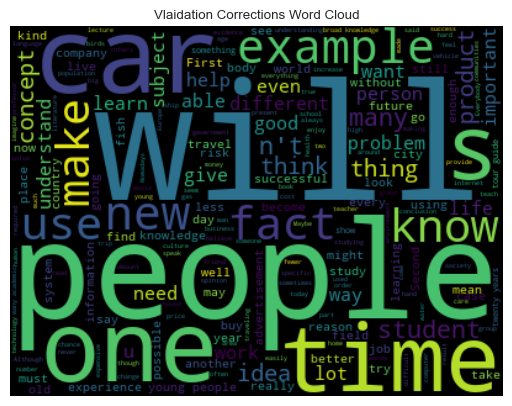

In [25]:
# word cloud display
eda.worldcloud()

### Fine-Tune T5 LoRA with the Dataset

In [ ]:
# intializing training instance
model_trainer = T5LoRATrainer(tokenizer=tokenizer,
                              model=model,
                              output_dir=CHECKPOINT)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


[INFO] Initializing T5 LoRA Trainer
	[INFO] Model: t5-small
	[INFO] Device: cuda
	[INFO] LoRA Config: rank=4, alpha=8, dropout=0.1
	[INFO] Output Directory: /content/drive/MyDrive/Research Methods/Assignment2
[INFO] Apply LoRA to T5...
trainable params: 147,456 || all params: 60,654,080 || trainable%: 0.2431
	[INFO] LoRA applied successfully to 2 target modules
	[INFO] Model moved to device: cuda
	[INFO] Data collator configured for dynamic padding

T5 LoRA Trainer initialized successfully!


In [ ]:
# fine-tune the model
trainer, result = model_trainer.trainer(train_dataset=train_dataset,
                                        val_dataset=val_dataset,
                                        batch_size=4,
                                        num_epochs=3,
                                        warmup_ratio=0.1,
                                        weight_decay=0.01)

[INFO] Starting Training with Hyperparameter:
	[INFO] Learning Rate: 0.0001 (LoRA optimal range)
	[INFO] Batch Size: 4 (effective: 8 with grad accum)
	[INFO] Epochs: 3 (LoRA converges fast)
	[INFO] Warmup Ratio: 0.1 (standard transformer practice)
	[INFO] Weight Decay: 0.01 (light regularization)
[INFO] Starting Training...
	[INFO] Dataset size: 3,016 training examples
	[INFO] Dataset size: 672 validation examples


/tmp/ipython-input-10-4462642.py:592: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Gleu,Meteor,Bertscore F1,Bertscore Precision,Bertscore Recall,Prediction Length,Reference Length,Vocab Overlap Ratio,Positive Length Changes,Evaluation Type,Num Samples
1,1.060600,0.805000,0.466457,0.772143,0.747010,0.676882,0.869919,25.483631,16.947917,0.652461,459,comprehensive,672
2,0.944700,0.729530,0.450528,0.771580,0.742101,0.664236,0.879429,26.882440,16.947917,0.655930,490,comprehensive,672
3,0.983300,0.714312,0.452735,0.773378,0.743347,0.665266,0.881321,26.915179,16.947917,0.657117,489,comprehensive,672


[DEBUG] Looking at evaluation result:<transformers.trainer_utils.EvalPrediction object at 0x7aa7dec77b50>
	[INFO] Computing Comprehensive Evaluation Metrics...
	[INFO] Evaluating 672 Predictions...
	[INFO] Computing GLEU Score...
	[INFO] Computing BERTScore--Precision Recall & F1...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

	[INFO] Computing METEOR Score...
	[INFO] Computing Comprehensive Statistics...
Evaluation Complete:
	[INFO] GLEU: 0.4665
	[INFO] METEOR: 0.7721
	[INFO] BERTSCORE:
		[INFO] Precision: 0.6769
		[INFO] Recall: 0.8699
		[INFO] F1: 0.7470

	[INFO] Statistics:
                     Metric       Value
                num_samples  672.000000
           total_references  672.000000
avg_references_per_sentence    1.000000
      avg_prediction_length   25.483631
      min_prediction_length    4.000000
      max_prediction_length   61.000000
      std_prediction_length   10.570611
 avg_prediction_char_length  129.099702
 std_prediction_char_length   54.709655
       avg_reference_length   16.947917
       min_reference_length    2.000000
       max_reference_length   61.000000
       std_reference_length    8.897664
  avg_reference_char_length   94.319940
  std_reference_char_length   50.169359
      avg_length_difference    8.535714
      std_length_difference   10.750910
    positive_length_chan

Plotting the Metrics

[{'epoch': 0.13262599469496023, 'grad_norm': 0.4347858428955078, 'learning_rate': 4.0350877192982455e-05, 'loss': 1.6372, 'step': 50}, {'epoch': 0.26525198938992045, 'grad_norm': 0.8019566535949707, 'learning_rate': 8.421052631578948e-05, 'loss': 1.5468, 'step': 100}, {'epoch': 0.3978779840848806, 'grad_norm': 1.2876077890396118, 'learning_rate': 9.685349065880039e-05, 'loss': 1.3945, 'step': 150}, {'epoch': 0.5305039787798409, 'grad_norm': 1.493607521057129, 'learning_rate': 9.20353982300885e-05, 'loss': 1.2977, 'step': 200}, {'epoch': 0.6631299734748011, 'grad_norm': 0.9826484322547913, 'learning_rate': 8.711897738446412e-05, 'loss': 1.1857, 'step': 250}, {'epoch': 0.7957559681697612, 'grad_norm': 0.827146053314209, 'learning_rate': 8.220255653883972e-05, 'loss': 1.1019, 'step': 300}, {'epoch': 0.9283819628647215, 'grad_norm': 0.711720883846283, 'learning_rate': 7.728613569321535e-05, 'loss': 1.0606, 'step': 350}, {'epoch': 1.0610079575596818, 'grad_norm': 0.94032883644104, 'learning

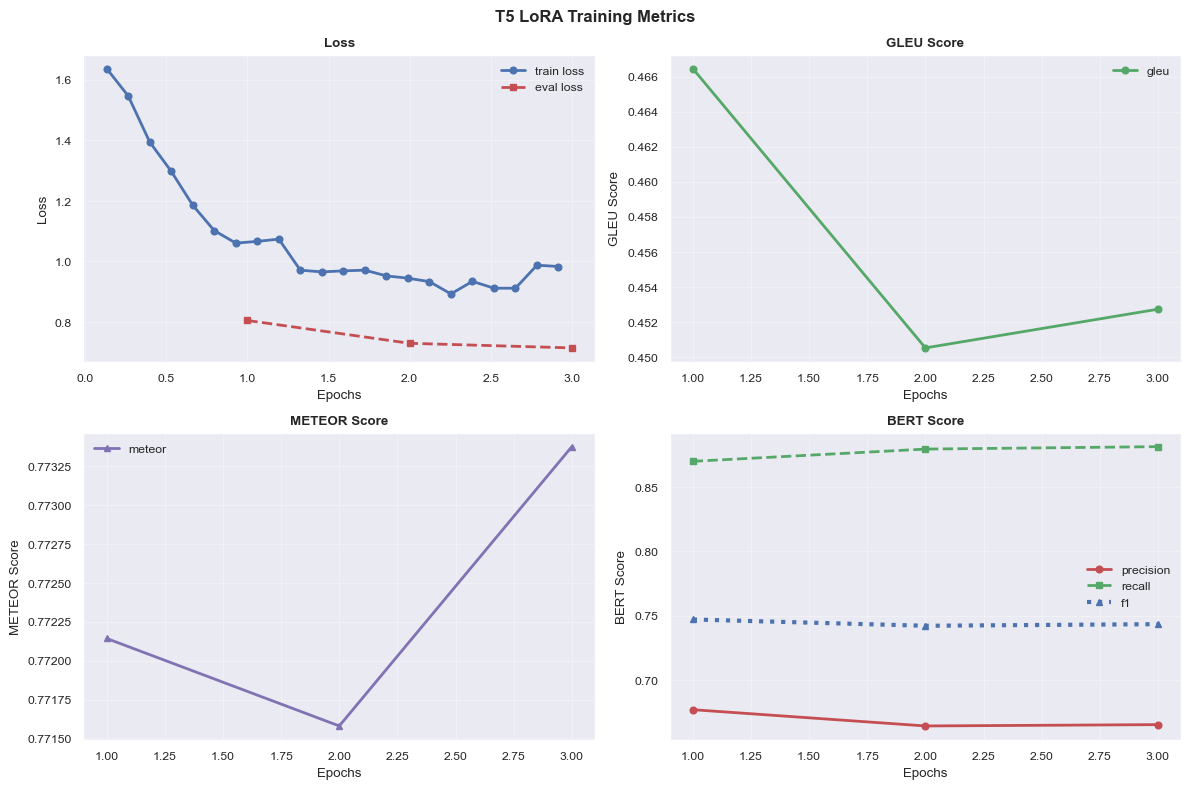

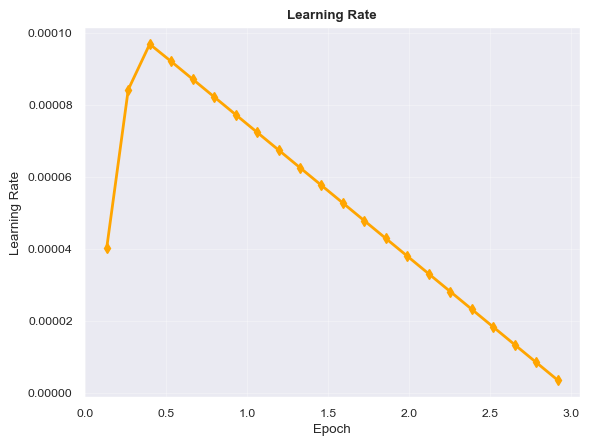

In [62]:
# plot the metrics
train_plots(
    r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment2\Checkpoints\trainer_state.json", IMAGE_SAVEPOINT)

### Trained Model Testing

In [ ]:
test_result = model_test()

### Inference On Trained Model
